In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.distributions as dist

sys.path.append("..")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

<module 'src.models' from '/home/jhaberbe/Projects/Personal/ate/notebook/../src/models.py'>

# Data Setup

In [29]:

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
adata = adata[adata.obs["folder"].eq("05-27")]
adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

# Data Setup
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)
data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
category_mapping

# Model Setup
nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

# Send to proper devices.
device = "cuda"
data.to(device)
nb_model.to(device)

# Training routine.
optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 2_000

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()

    logits, dispersion = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area, 
        data.edge_index
    )

    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
    if epoch % 100 == 0:
        print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

In [110]:
torch.save(nb_model.state_dict(), "../models/gatv2_nb_model.pth")
nb_model.load_state_dict(torch.load("../models/gatv2_nb_model.pth"))

<All keys matched successfully>

# Example of Treatment Effect
- For example, what is the expected effect of lipid droplets, conditioned on the neighborhood.

In [3]:
def perform_lipid_perturbation(
        adata,
        data,
        cell_type,
        nb_model
    ):
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)

    results = {}

    for idx in tqdm(indices):
        x_clone = data.x.clone()
        lipid_droplet_area_clone = data.lipid_droplet_area.clone()
        lipid_droplet_area_clone[idx] = 0.0
        nb_model.eval()
        with torch.no_grad():
            logits, dispersion = nb_model(
                data.cell_type_encoded.int(), 
                data.lipid_droplet_area, 
                data.edge_index
            )

            results[idx] = logits[idx].cpu().detach()

    treatment = pd.DataFrame(
        results, 
        index=adata.var_names
    ).T

    logits, _ = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area > 0, 
        data.edge_index
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return (treatment - null) \
        .assign(mean_area = np.log1p(adata.obs["lipid_droplet_area"]).iloc[treatment.index].tolist())

# Visualization

Could probably be done with gaussian processes.
- Maybe the output linear layer could be done with GPs too!

In [ ]:
mean_area = np.log1p(adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].obs["lipid_droplet_area"])

expressed = (adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].layers["transcript"] > 1).mean(axis=0) > .3

(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).plot.kde()
(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).sort_values()[expressed]

<Axes: xlabel='mean_area', ylabel='TPH2'>

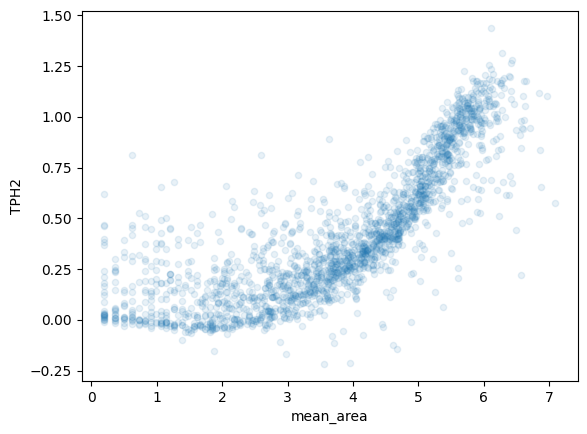

In [530]:
(treatment - null).assign(mean_area = mean_area.tolist()).plot.scatter(
    x="mean_area",
    y="TPH2",
    alpha = 0.1
)

# Changes cell type in the neighborhood.

In [4]:
import torch
from tqdm import tqdm
import random
import pandas as pd

import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
        adata,
        data,
        cell_type_testing,
        cell_type_perturb,
        category_mapping,
        nb_model
    ):

    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]

    # full edge index
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # remap everything to local subgraph
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset]

        center_idx = mapping.item()  # local index of target cell
        num_nodes = len(subset)

        # Find neighbors within the subgraph (1-hop)
        neighbors = sub_edge_index[1][sub_edge_index[0] == center_idx].tolist()
        if not neighbors:
            continue  # skip if isolated

        chosen_neighbor = random.choice(neighbors)
        i = 0
        while (cell_type_clone[chosen_neighbor].argmax() == target_cell_type) and i < 10:
            chosen_neighbor = random.choice(neighbors)
            i += 1

        # Replace cell type
        cell_type_clone[chosen_neighbor][cell_type_clone[chosen_neighbor].argmax()] = 0
        cell_type_clone[chosen_neighbor][target_cell_type] = 1

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null

In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [471]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (average_treatment_effect.mean(axis=0))[mean_expression > 0.5].abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if (mean_expression.loc[gene] > 0.5) else None)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)


<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

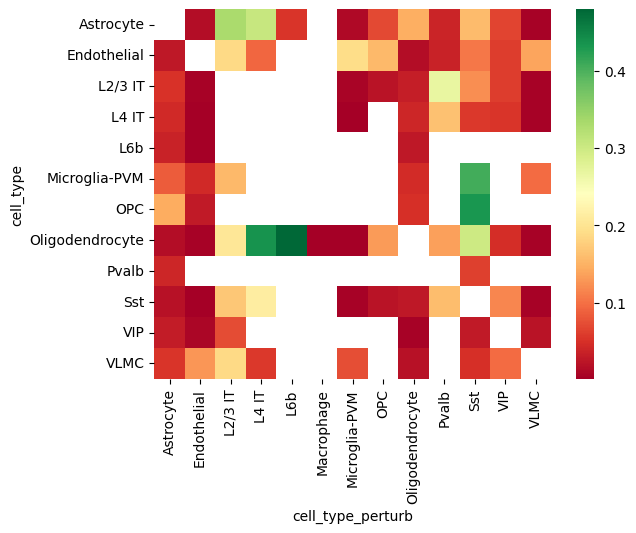

In [472]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

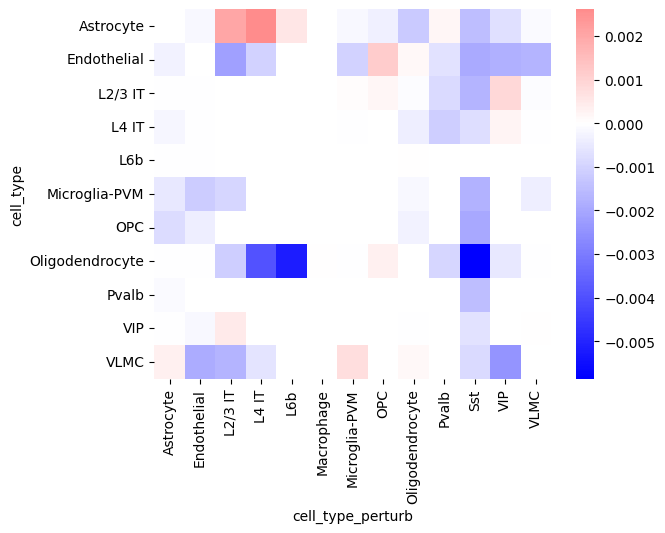

In [486]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(
    index="cell_type", 
    columns="cell_type_perturb", 
    values="LAMP1"
)
sns.heatmap(heatmap, cmap="bwr", center=0)

# What's the effect of inducing lipid droplet changes in a cell.

- Suppose we want to see what the effect is on a cell if we change the amount of lipid in its' neighboring cells, where will the effect be strongest.

In [5]:
import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_lipid_perturbation(
    adata, 
    data, 
    cell_type_testing, 
    cell_type_perturb, 
    category_mapping,
    new_lipid_value=0.0, 
    min_lipid_size=4.0
):
    # Todo: adjust so that we can add new bounds, question addition vs removal of lipid droplet.
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0.0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]


    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # Get subgraph feature tensors
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset].clone()

        center_idx = mapping.item()  # local index of target cell

        # Find matching cell type in subgraph (excluding the target)
        candidate_indices = [
            i for i in range(len(subset))
            if ((i != center_idx) & (cell_type_clone[i].argmax().item() == target_cell_type) & (lipid_droplet_area[i] > min_lipid_size))
        ]

        if not candidate_indices:
            continue  # skip if no perturbable cell found

        chosen_perturb_idx = random.choice(candidate_indices)

        # Replace lipid droplet value of that cell
        lipid_droplet_area[chosen_perturb_idx] = new_lipid_value

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null


In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_lipid_perturbation(
            adata, 
            data, 
            cell_type, 
            cell_type_perturb, 
            category_mapping,
            new_lipid_value=0.0
        )
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [490]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

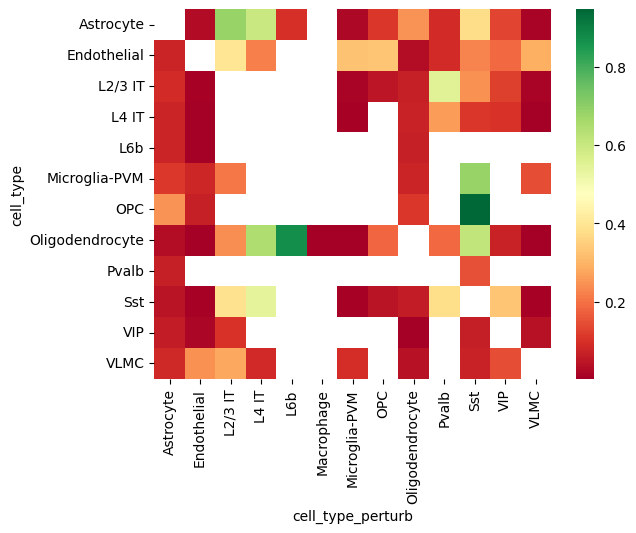

In [491]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

# Generalized Pipeline

In [6]:
# Pipeline to test all specimens:
import os
import pickle
import torch
import wandb
import scanpy as sc
import torch.distributions as dist
from IPython.display import clear_output

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
for folder in adata.obs["folder"].unique()[6:]:
    adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
    adata = adata[adata.obs["folder"].eq(folder)]
    adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

    # Data Setup
    data = utils.generate_torch_geometric_data(adata)
    data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
    data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
    data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
    data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
    data.size_factors = utils.counts_to_size_factors(data.total_counts)
    data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

    category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
    category_mapping

    # Model Setup
    nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

    # Send to proper devices.
    device = "cuda"
    data.to(device)
    nb_model.to(device)

    # Training routine.
    optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
    num_epochs = 10_000

    wandb.init(project="ate", name=f"{folder}")

    for epoch in range(num_epochs):
        nb_model.train()
        optimizer.zero_grad()

        logits, dispersion = nb_model(
            data.cell_type_encoded.int(), 
            data.lipid_droplet_area, 
            data.edge_index
        )

        nb_dist = dist.NegativeBinomial(
            logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
            total_count=dispersion
        )
        log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
        loss = -log_likelihood
        loss.backward()
        optimizer.step()
        wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
        if epoch % 100 == 0:
            print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

    torch.save(nb_model.state_dict(), f"../models/{folder}.pth")
    nb_model.load_state_dict(torch.load(f"../models/{folder}.pth"))

    lipid_perturbation = {
        cell_type: perform_lipid_perturbation(adata, data, cell_type, nb_model)
        for cell_type in adata.obs["cell_type"].unique()
    }

    neighbor_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    neighbor_lipid_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_lipid_perturbation(
                adata, 
                data, 
                cell_type, 
                cell_type_perturb, 
                category_mapping,
                new_lipid_value=0.0
            )
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    # Ensure the output directory exists
    os.makedirs(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}", exist_ok=True)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/lipid_perturbation.pickle", "wb") as f:
        pickle.dump(lipid_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_lipid_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_lipid_perturbation, f)

    clear_output()

# Perturb Differences

In [7]:
import pickle
import pathlib

per_folder_lipid_impact = {
    folder.name: pickle.load(open(folder/"lipid_perturbation.pickle", "rb"))
    for folder in pathlib.Path("/home/jhaberbe/Projects/Personal/ate/output").glob("*")
}

In [43]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.interpolate import UnivariateSpline

def fit_spline(df, gene="PLIN2"):
    X = df[gene]
    y = df["mean_area"]
    sorted_index = y.sort_values().index
    X = X.loc[sorted_index]
    y = y.loc[sorted_index]
    return UnivariateSpline(y, X)

def compute_spline_covariance(fitted_splines: list, sigma = 0.5):
    spline_matrix = np.stack([spline(np.linspace(0, 7, 200)) for spline in fitted_splines])

    pairwise_dists = np.linalg.norm(
        spline_matrix[:, None, :] - spline_matrix[None, :, :], axis=2
    )
    median_dist = np.median(pairwise_dists)
    sigma = median_dist if median_dist > 0 else sigma
    K = rbf_kernel(spline_matrix, gamma=1/(2*sigma**2))

    return spline_matrix, K - np.eye(K.shape[0])

computed_splines = {}
for gene in adata.var_names:
    gene_splines =  [fit_spline(per_folder_lipid_impact[folder]["Astrocyte"], gene=gene) for folder in per_folder_lipid_impact]
    computed_splines[gene] = compute_spline_covariance(gene_splines)

np.float64(33.05272077095715)

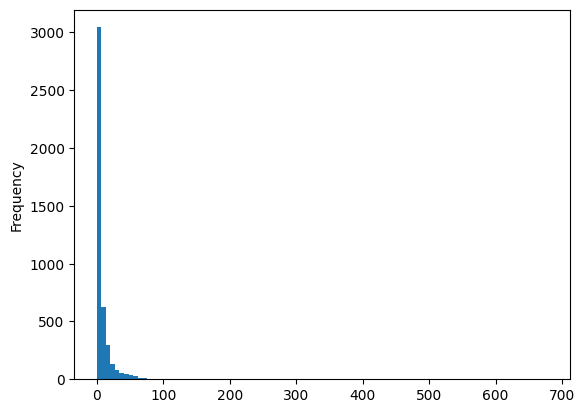

In [65]:
import numpy as np
from statsmodels.tsa.stattools import kpss
import numpy as np

def is_nonstationary(ts, threshold=35):
    """
    Returns True if the residual sum of squares from the mean exceeds a threshold.
    """
    mean = np.mean(ts)
    rss = np.sum((ts - mean) ** 2)
    return rss > threshold

import numpy as np
import pandas as pd

def compute_rss_residuals_per_sample(gene_data_dict):
    """
    For each gene and sample, compute the residual sum of squares (RSS)
    from the mean (i.e., how much the sample's time series deviates from flatness).

    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)

    Returns:
        pd.Series with MultiIndex (gene_name, sample_index)
    """
    rss_records = []

    for gene, (data, _) in gene_data_dict.items():
        for i, ts in enumerate(data):
            mean_val = np.mean(ts)
            rss = np.sum((ts - mean_val) ** 2)
            rss_records.append(((gene, i), rss))

    index = pd.MultiIndex.from_tuples([k for k, _ in rss_records], names=["gene", "sample"])
    values = [v for _, v in rss_records]

    return pd.Series(values, index=index, name="RSS")

compute_rss_residuals_per_sample(computed_splines).plot.hist(bins=100)
compute_rss_residuals_per_sample(computed_splines).quantile(.95)

In [96]:
def find_nonflat_high_cov_genes(
    gene_data_dict,
    rss_threshold=33,
    cov_threshold=0.5,
    min_nonflat_samples=2
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        rss_threshold: float
            Threshold for residual sum of squares from the mean
        cov_threshold: float
            Minimum average covariance between nonflat samples
        min_nonflat_samples: int
            Minimum number of non-flat samples required to consider the gene
    
    Returns:
        result_dict: dict
            { gene_name: [sample indices] } for genes meeting the criteria
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Test each sample for deviation from mean (non-flatness)
        nonflat_idxs = [
            i for i in range(n_samples) if is_nonflat(data[i], threshold=rss_threshold)
        ]

        # Step 2: Check count
        if len(nonflat_idxs) < min_nonflat_samples:
            continue

        # Step 3: Extract submatrix of covariances
        cov_subset = cov[np.ix_(nonflat_idxs, nonflat_idxs)]
        upper_tri_val


def find_nonstationary_high_cov_genes(
    gene_data_dict, 
    alpha=0.05, 
    cov_threshold=0.6, 
    min_nonstationary_samples=6
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        alpha: float
            Significance level for non-stationarity (KPSS)
        cov_threshold: float
            Minimum average covariance between nonstationary samples
        min_nonstationary_samples: int
            Minimum number of non-stationary samples required to consider the gene
    
    Returns:
        result_dict: dict
            { gene_name: [sample indices] } for genes meeting the criteria
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Test each sample for non-stationarity
        nonstationary_idxs = [
            i for i in range(n_samples) if is_nonstationary(data[i], alpha)
        ]

        # Step 2: Check count
        if len(nonstationary_idxs) < min_nonstationary_samples:
            continue

        # Step 3: Extract submatrix of covariances
        cov_subset = cov[np.ix_(nonstationary_idxs, nonstationary_idxs)]
        upper_tri_vals = cov_subset[np.triu_indices(len(nonstationary_idxs), k=1)]

        # Step 4: Compute average covariance
        if len(upper_tri_vals) == 0:
            continue  # only 1 nonstationary sample
        avg_cov = np.mean(upper_tri_vals)

        if avg_cov > cov_threshold:
            result[gene] = nonstationary_idxs

    return result

find_nonstationary_high_cov_genes(computed_splines)

{'CDH12': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'MYO5B': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'OPALIN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'SRGN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [97]:
import numpy as np

def find_genes_with_cov_and_rss(
    gene_data_dict,
    cov_threshold=0.6,
    min_cov_connections=10,
    rss_threshold=50.0,
    min_rss_samples=6
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        cov_threshold: float
            Minimum covariance to consider two samples as connected
        min_cov_connections: int
            Minimum number of lower triangle cov values above the threshold
        rss_threshold: float
            Minimum RSS from zero to consider a sample non-flat
        min_rss_samples: int
            Minimum number of such non-flat samples required
    
    Returns:
        result: dict
            { gene_name: [indices of high-RSS samples] }
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Count lower triangle covariances > threshold
        tril_indices = np.tril_indices(n_samples, k=-1)
        cov_values = cov[tril_indices]
        num_high_cov = np.sum(cov_values > cov_threshold)

        if num_high_cov < min_cov_connections:
            continue  # too few connections

        # Step 2: Find which samples have RSS from 0 > rss_threshold
        rss_values = np.sum((data - 0.0) ** 2, axis=1)
        high_rss_indices = np.where(rss_values > rss_threshold)[0]

        if len(high_rss_indices) < min_rss_samples:
            continue  # too few expressive samples

        result[gene] = high_rss_indices.tolist()

    return result

find_genes_with_cov_and_rss(computed_splines)

{'ANO3': [1, 4, 7, 8, 9, 11],
 'CD48': [1, 2, 4, 6, 7, 10],
 'CRYM': [0, 1, 4, 5, 8, 9, 11],
 'HS3ST2': [2, 4, 7, 8, 9, 10, 11],
 'MS4A6A': [1, 2, 4, 6, 7, 8],
 'NLRP3': [1, 4, 5, 6, 7, 8],
 'ROS1': [1, 4, 5, 7, 9, 11],
 'SAMD5': [1, 2, 4, 5, 7, 8, 9],
 'SFRP2': [4, 6, 7, 9, 10, 11],
 'SLC17A6': [1, 4, 5, 8, 9, 10, 11],
 'SST': [0, 3, 4, 5, 9, 10, 11],
 'ST18': [2, 4, 5, 6, 7, 8, 11]}

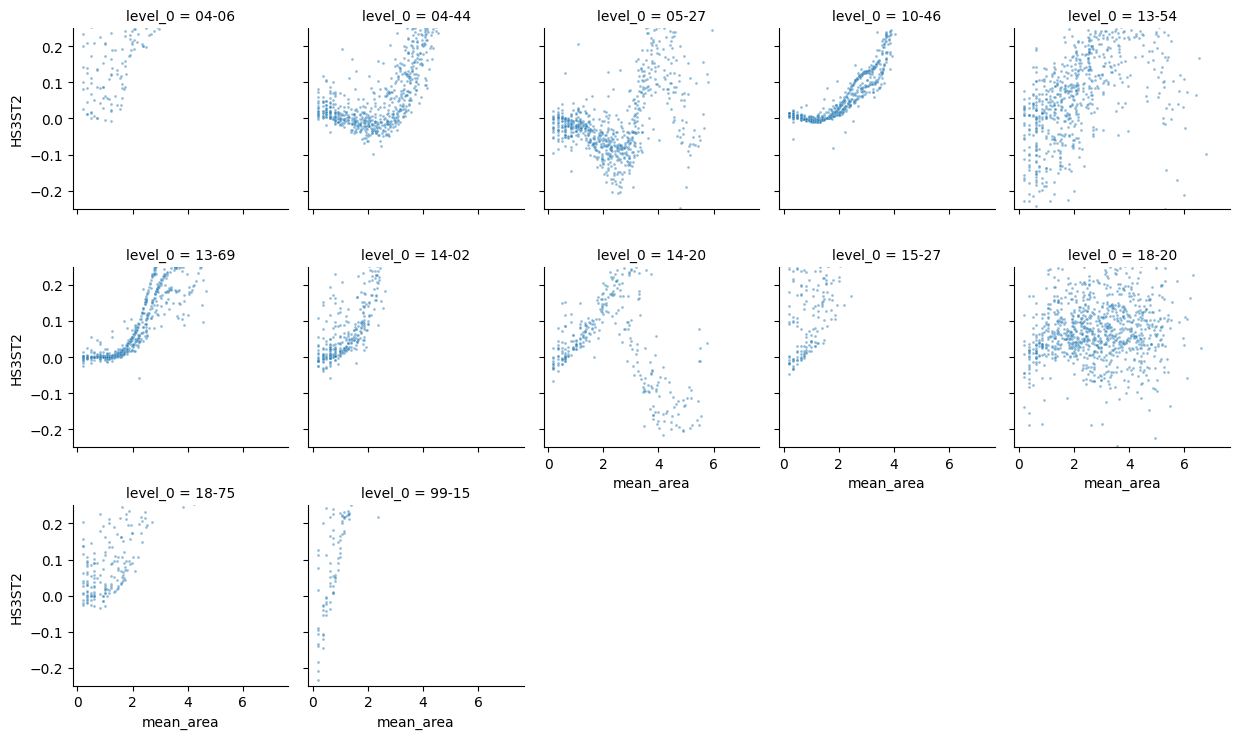

In [95]:
import seaborn as sns

combined_impacts = pd.concat({folder: per_folder_lipid_impact[folder]["Microglia-PVM"] for folder in per_folder_lipid_impact}) \
    .reset_index() \
    .drop("level_1", axis=1)
combined_impacts = combined_impacts.sort_values(by="level_0")

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    combined_impacts,
    col="level_0",
    col_wrap=5,  # adjust based on how many subplots per row you want
    height=2.5,
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.scatterplot,
    x="mean_area",
    y="HS3ST2",
    alpha=0.5,
    s=4,
    color="tab:blue"  # you can also vary this with hue if needed
)

# Set y-limits on all subplots
for ax in g.axes.flat:
    ax.set_ylim(-0.25, 0.25)

g.tight_layout()
plt.show()


In [54]:
adata.obs.drop_duplicates(subset=["folder"])[["folder", "group"]].sort_values(by="folder")

,folder,group
cell_id,,
aaabikmi-1,04-06,AD 44
aaaaegai-1,14-20,ND 33
aaaahejp-1,13-54,AD 33
aaaaapcl-1,05-27,AD 44
aaaacglc-1,15-27,AD 33
aaabchga-1,99-15,AD 44
aaaafefa-1,18-20,ND 33
aaaaioeb-1,18-75,ND 33
aaaamdhh-1,10-46,AD 33


## Random Thought
Good method to determine the covariance between multiple items, clustering by time.

  8%|▊         | 28/366 [00:03<00:35,  9.65it/s]/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 30%|██▉       | 108/366 [00:12<00:38,  6.76it/s]/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|██████████| 366/366 [00:42<00:00,  8.65it/s]


In [160]:
import numpy as np
from scipy.spatial.distance import cdist

def rbf_covariance(time_series, gamma=None):
    """
    Computes RBF kernel-based covariance between time series.

    Parameters:
        time_series: np.ndarray of shape (n_features, n_timepoints)
        gamma: float or None. If None, defaults to 1 / n_timepoints.

    Returns:
        cov: np.ndarray of shape (n_features, n_features)
    """
    n_features, n_timepoints = time_series.shape
    if gamma is None:
        gamma = 1.0 / n_timepoints

    # Pairwise squared Euclidean distances
    dists = cdist(time_series, time_series, metric='sqeuclidean')

    # Apply RBF kernel
    cov = np.exp(-gamma * dists)
    return cov

  7%|▋         | 25/366 [00:01<00:25, 13.14it/s]/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  8%|▊         | 31/366 [00:02<00:14, 22.44it/s]/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 25%|██▍       | 90/366 [00:03<00:08, 32.59it/s]/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length

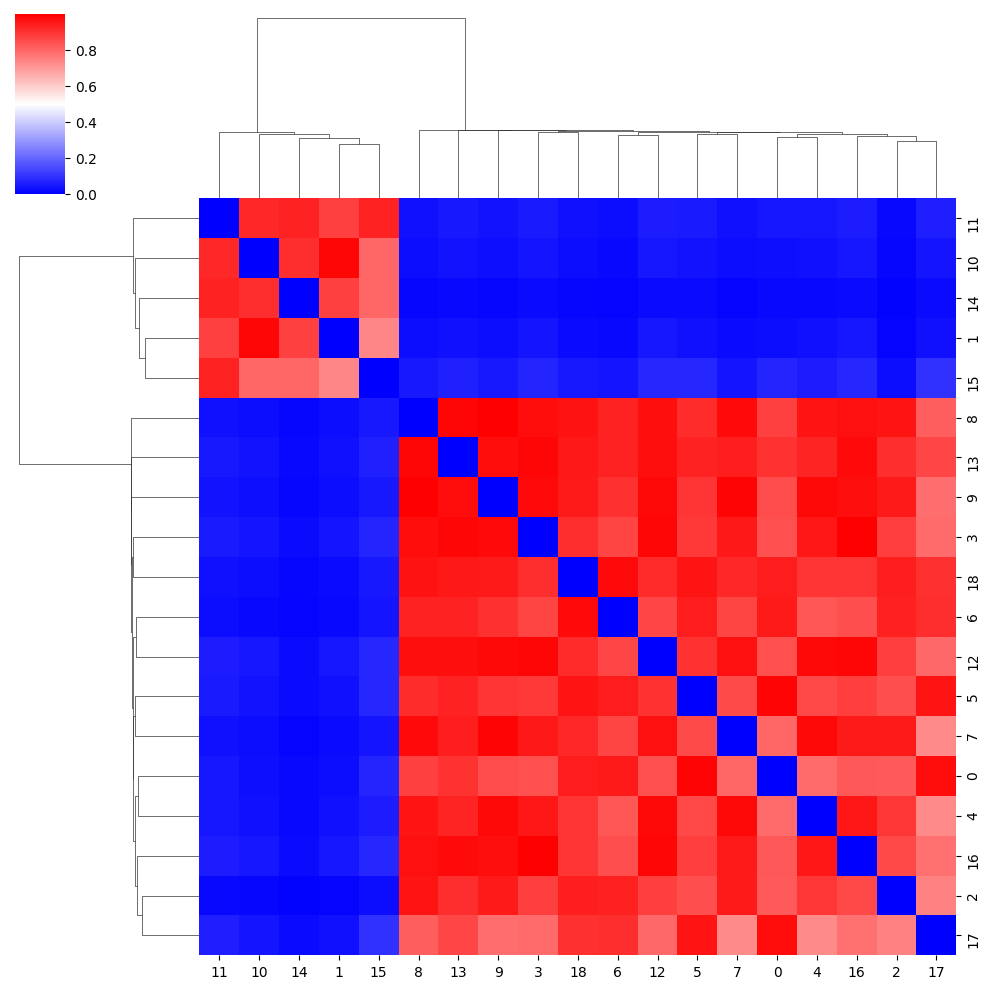

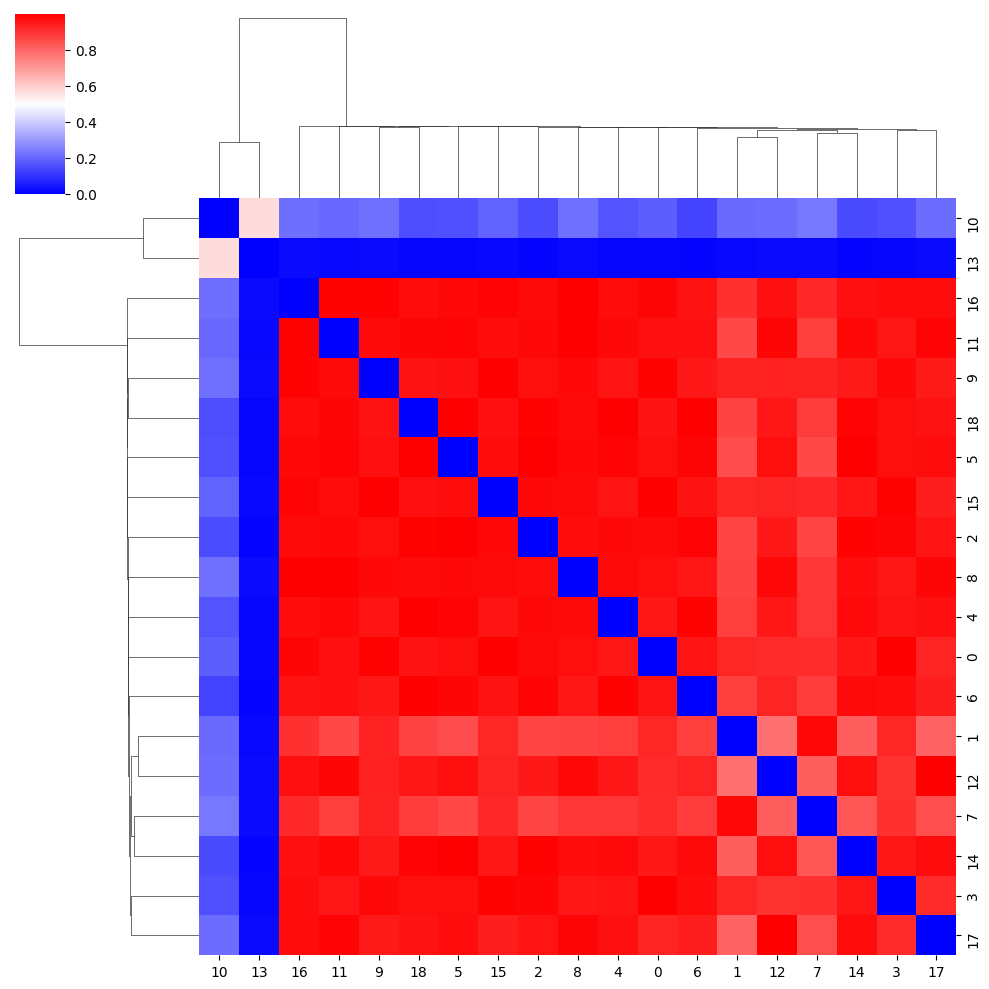

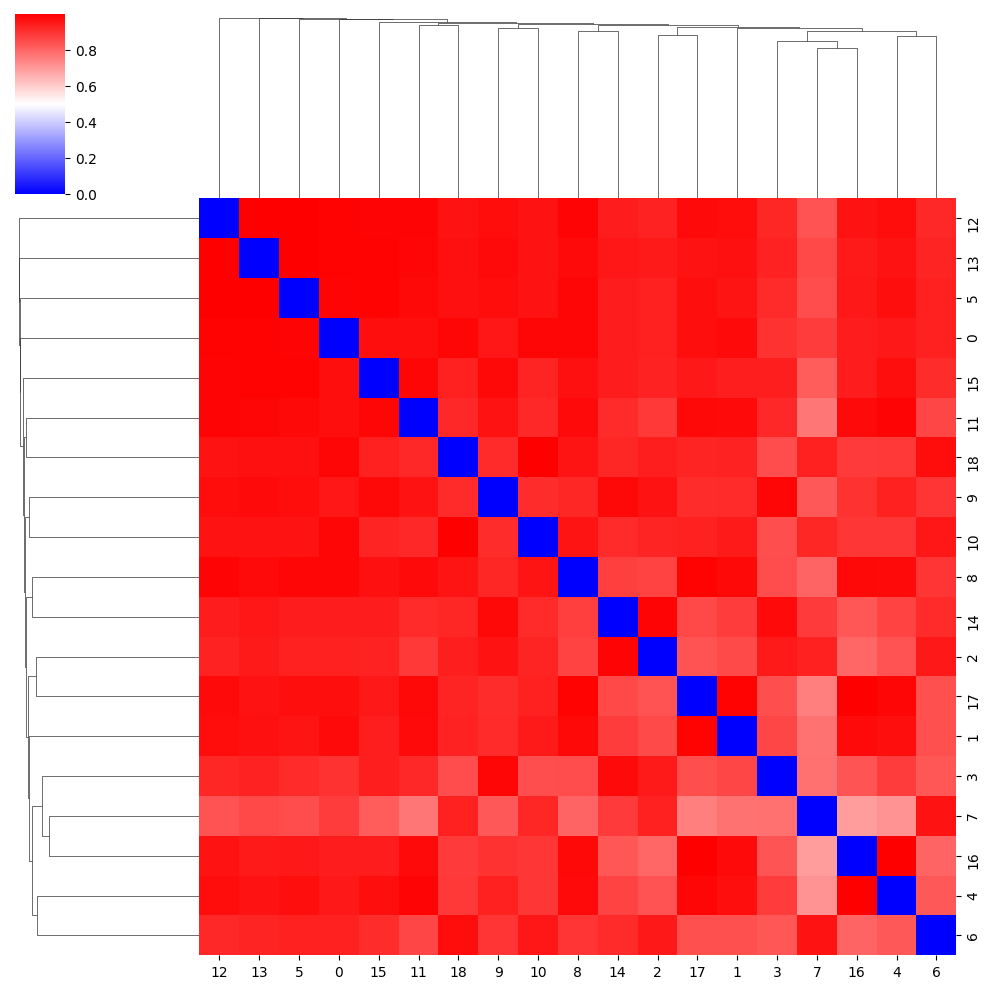

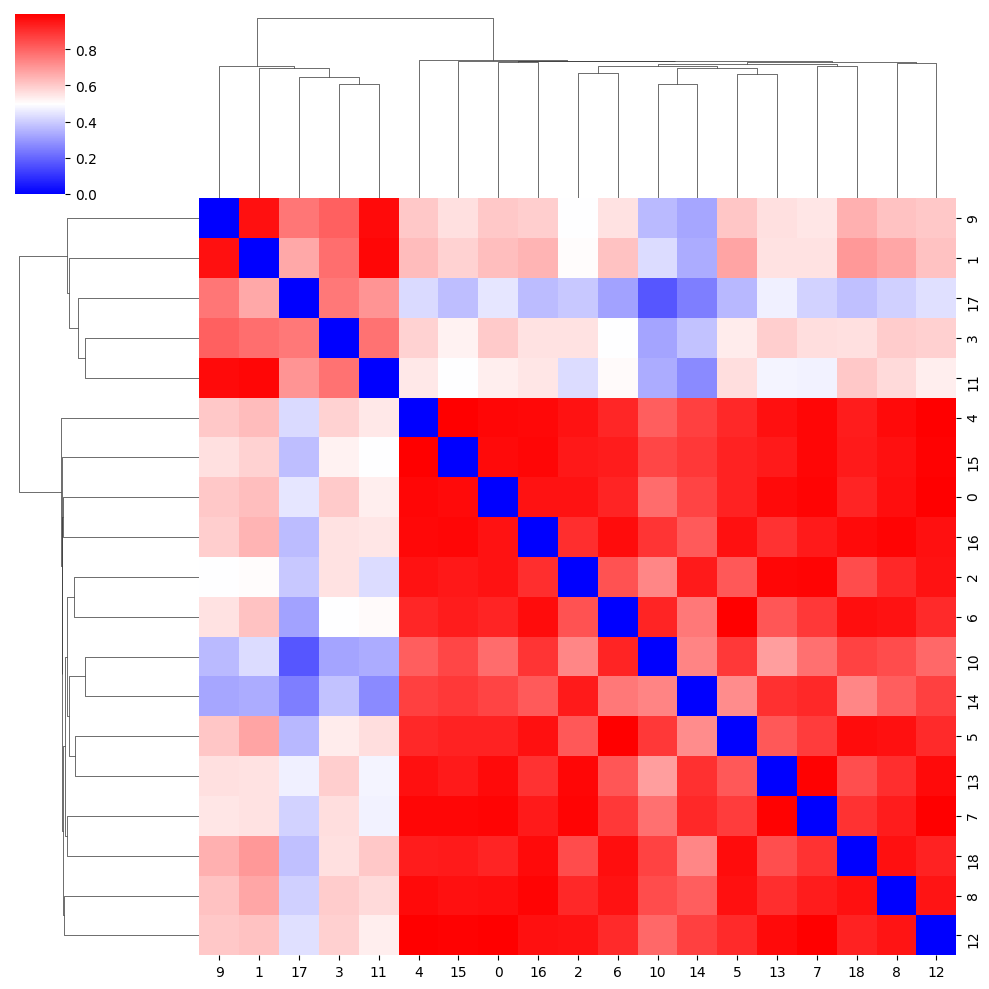

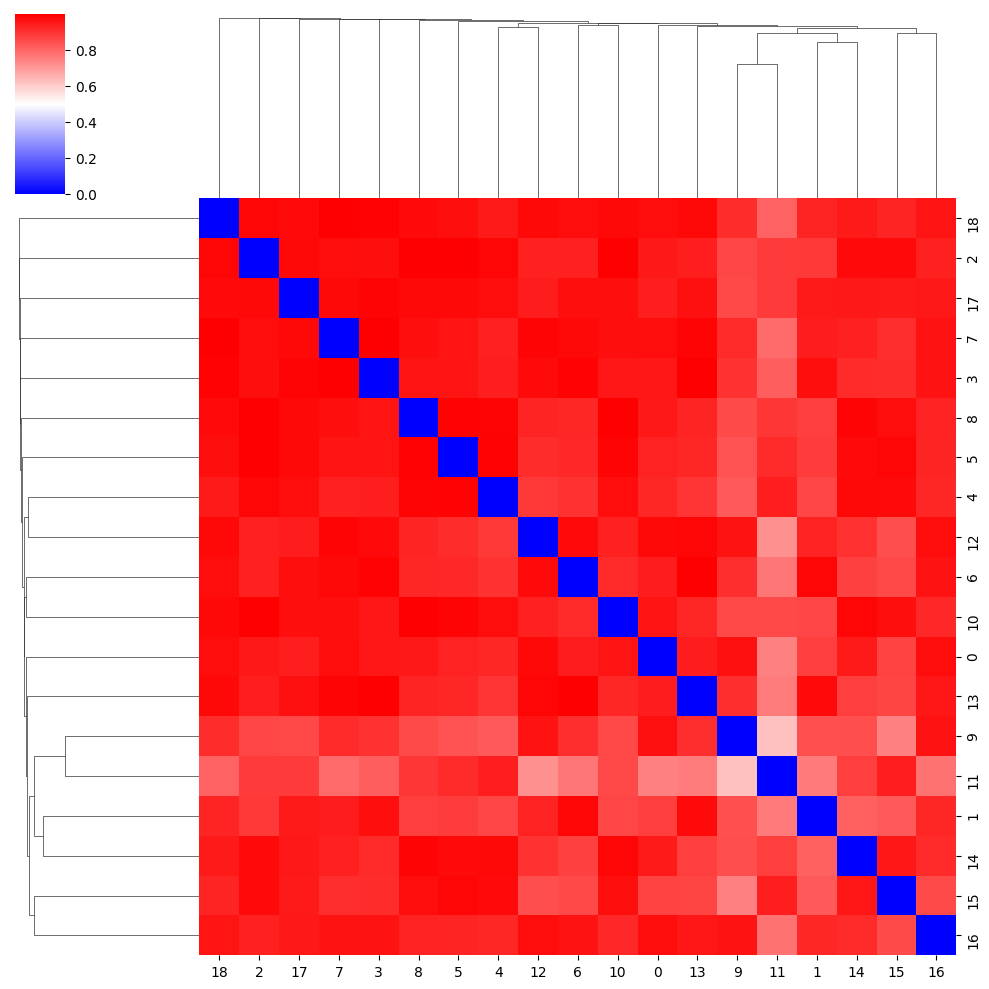

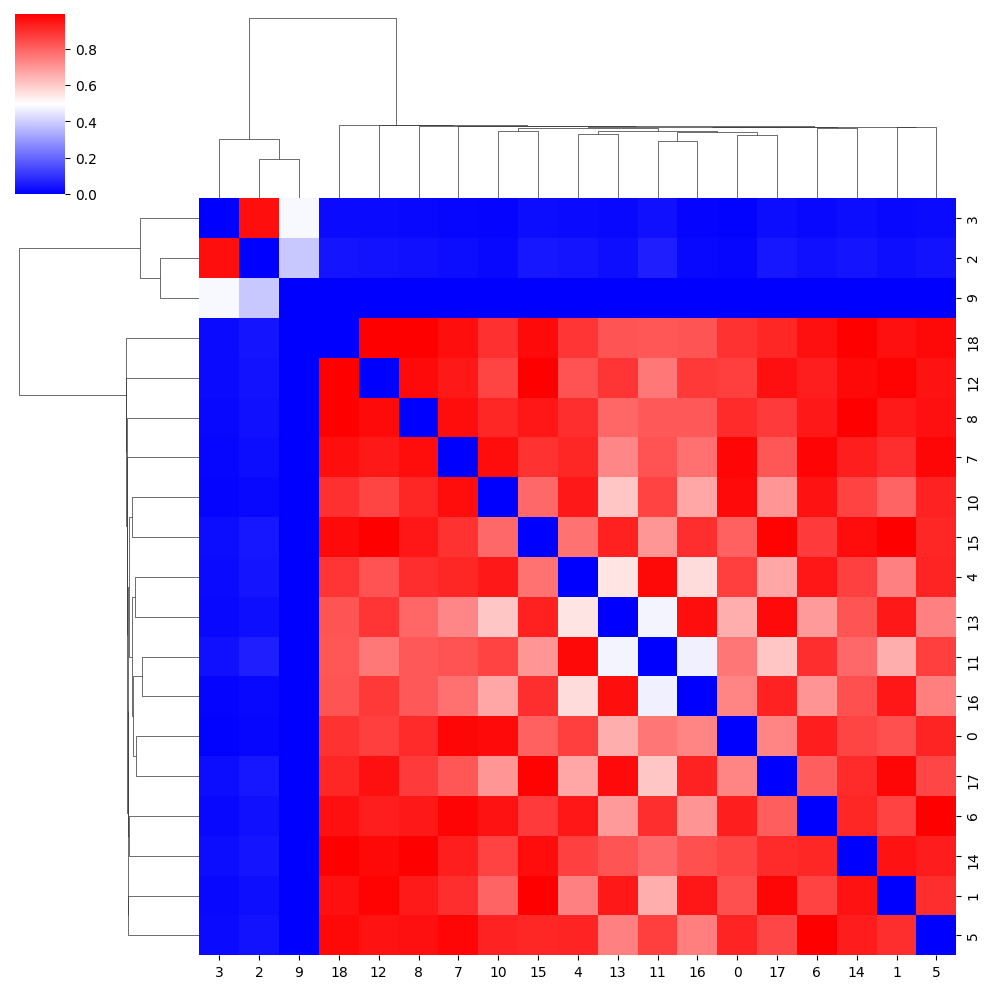

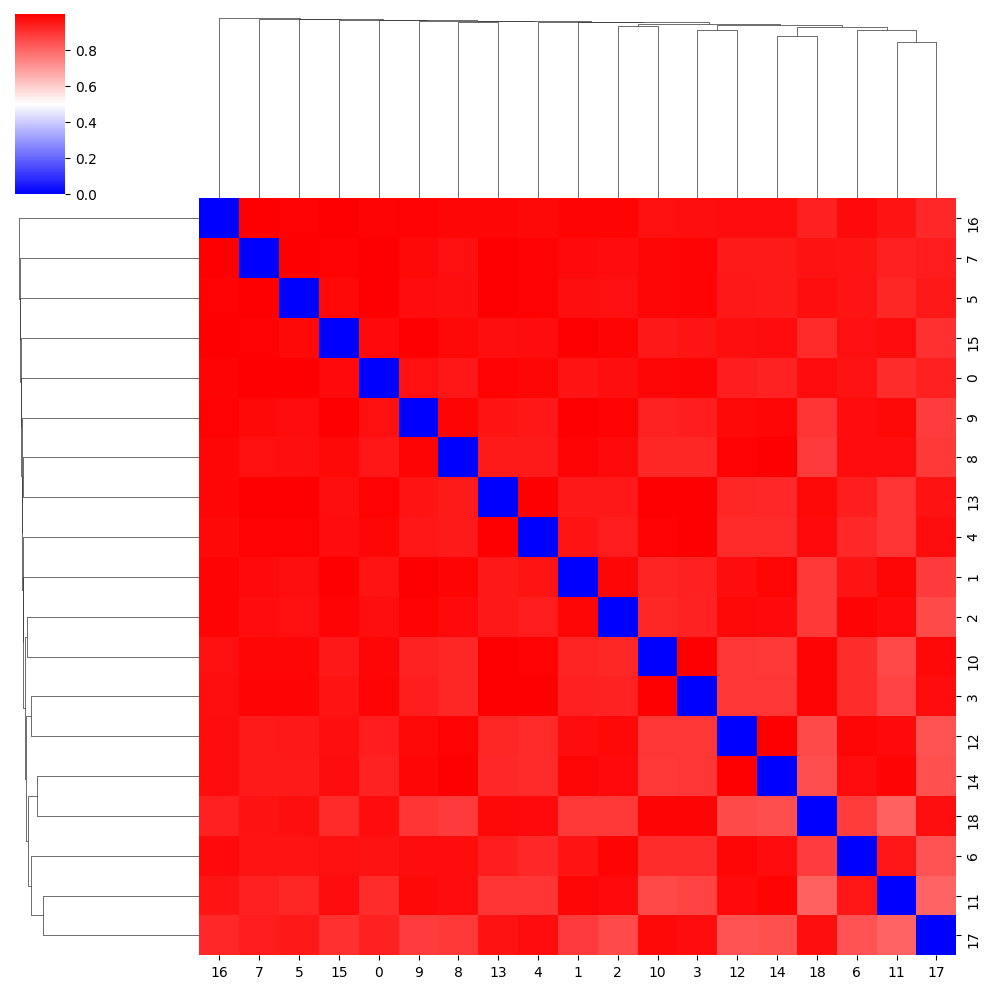

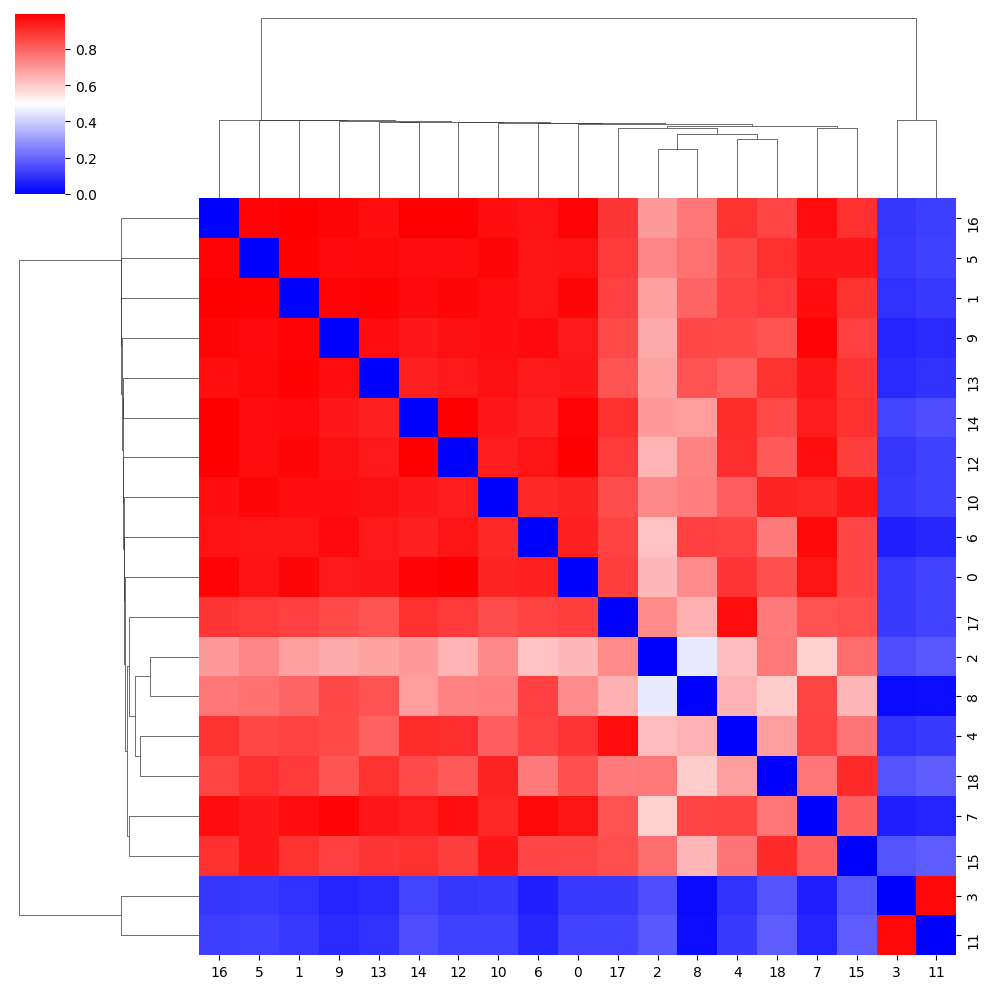

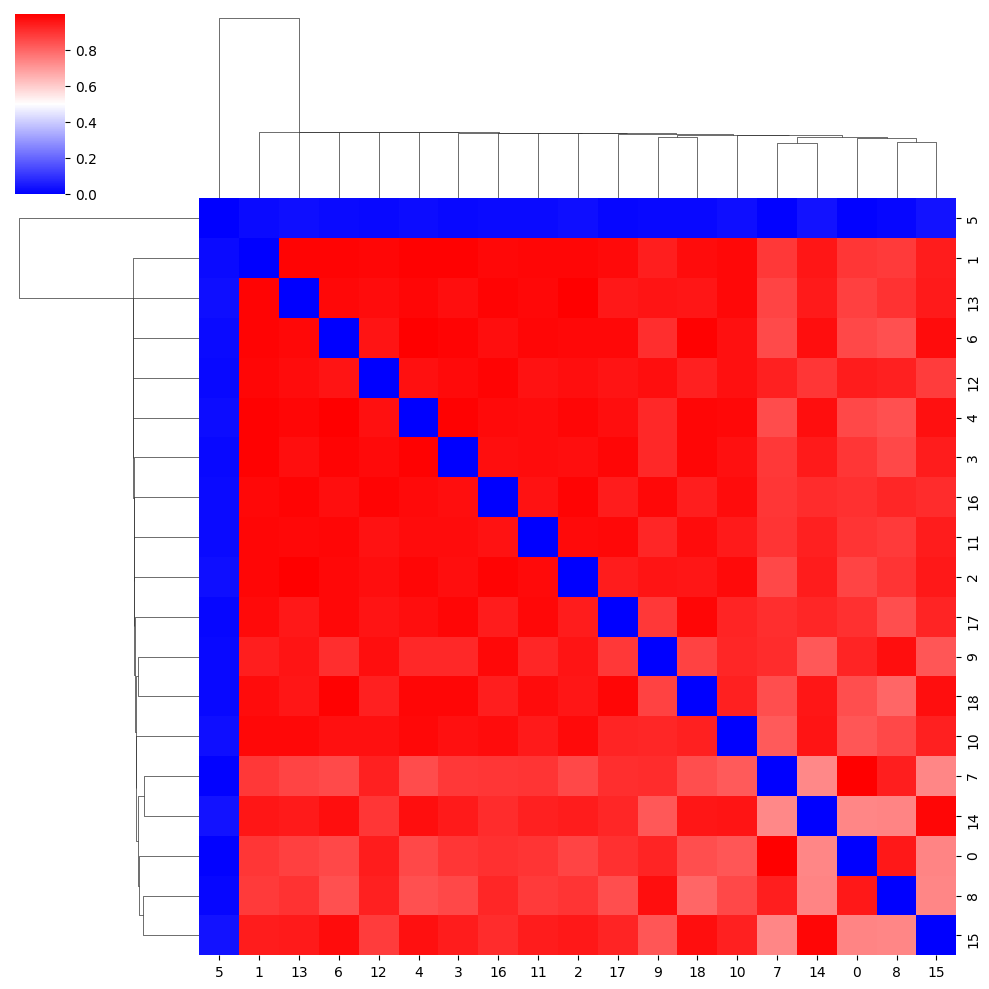

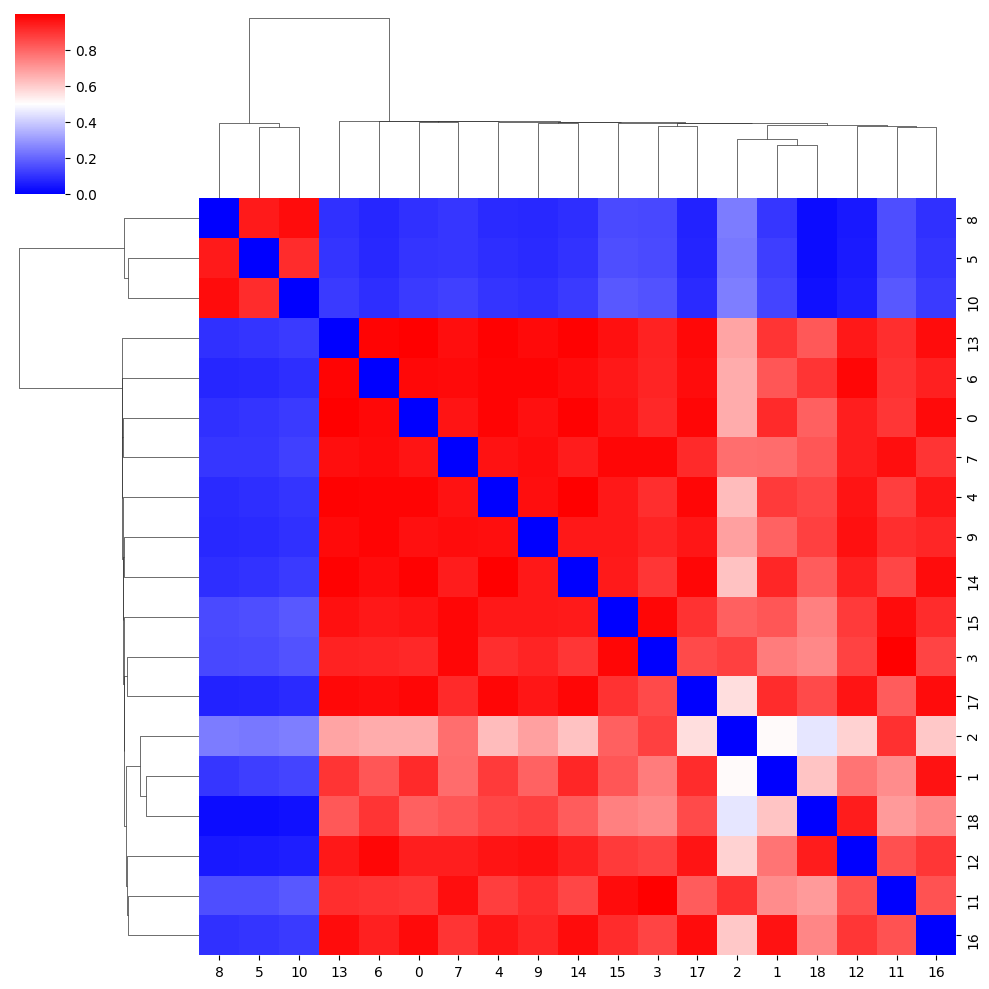

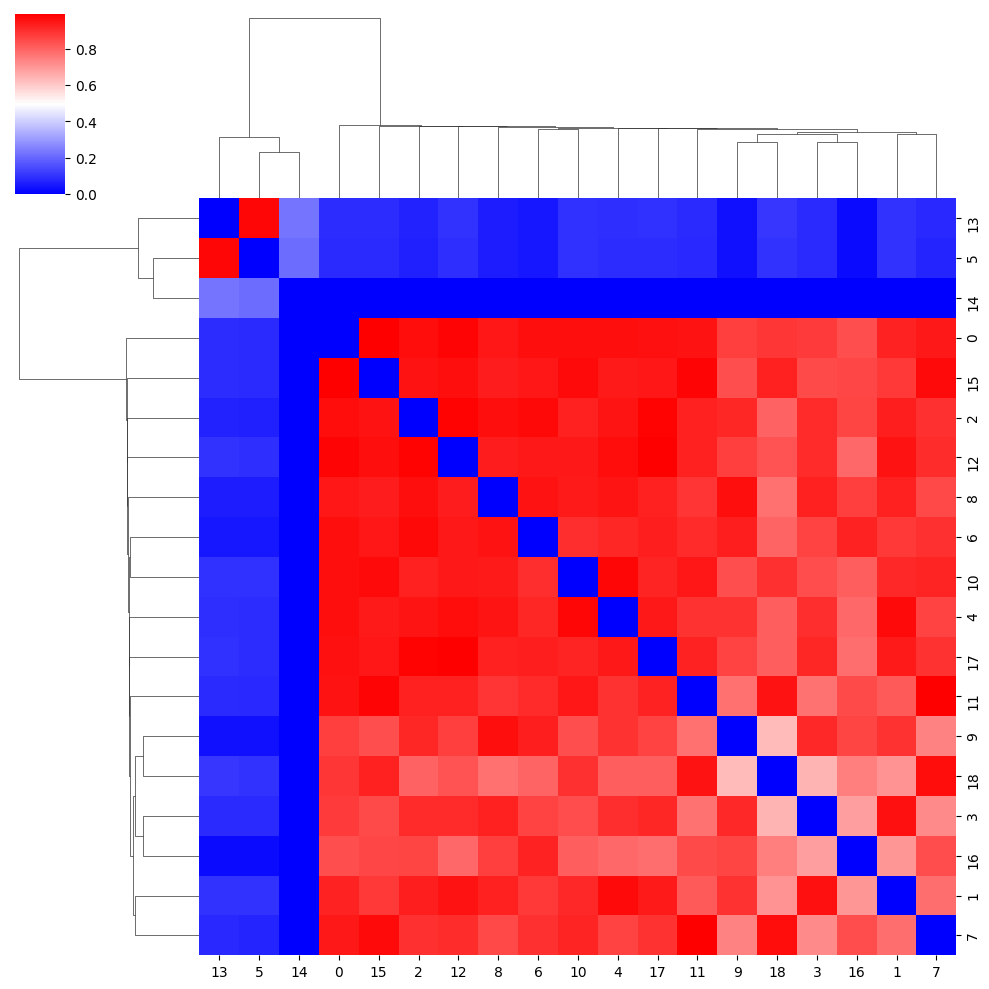

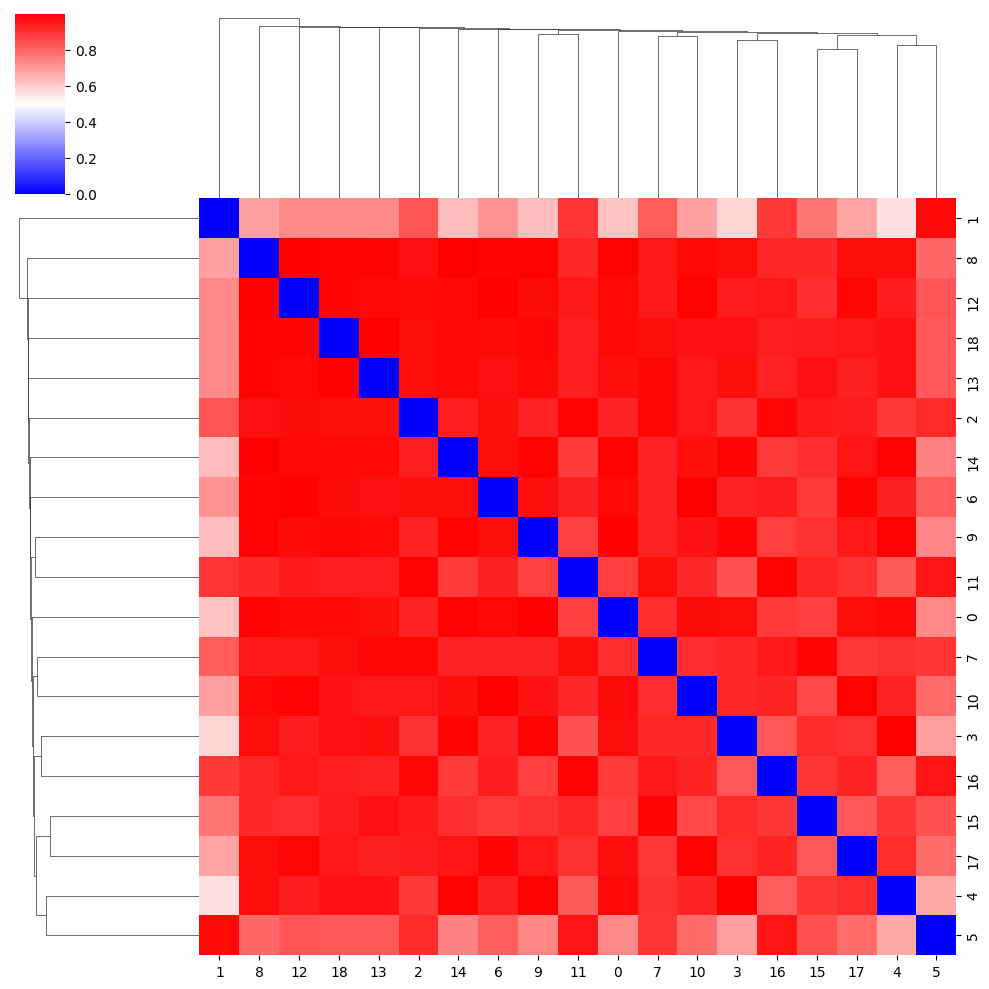

In [166]:
import numpy as np
from scipy.interpolate import UnivariateSpline, RBFInterpolator
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5), alpha=1e-2)


cell_type = "Microglia-PVM"

output = {}
for folder in per_folder_lipid_impact:
    sorted_index = per_folder_lipid_impact[folder][cell_type]["mean_area"].sort_values().index

    fitted_splines = {}
    for gene in tqdm(adata.var_names):
        X = per_folder_lipid_impact[folder][cell_type][gene].loc[sorted_index]
        y = per_folder_lipid_impact[folder][cell_type]["mean_area"].loc[sorted_index]
        gp.fit(y.values.reshape(-1, 1)[::2], X[::2])
        fitted_splines[gene] = gp.predict(np.linspace(y.min(), y.max(), 20).reshape(-1, 1))

    spline_matrix = np.stack([spline for spline in fitted_splines.values()])
    dists = squareform(pdist(spline_matrix, metric='euclidean'))  # or 'sqeuclidean'

    indices = pd.Series((spline_matrix ** 2).sum(axis=1), index=adata.var_names) > pd.Series((spline_matrix ** 2).sum(axis=1)).quantile(.95)
    sns.clustermap(
        rbf_covariance(spline_matrix[indices]) - np.eye(rbf_covariance(spline_matrix[indices]).shape[0]),
        cmap="bwr"
    )

    output[folder] = (
        spline_matrix,
        dists,
        indices
    )

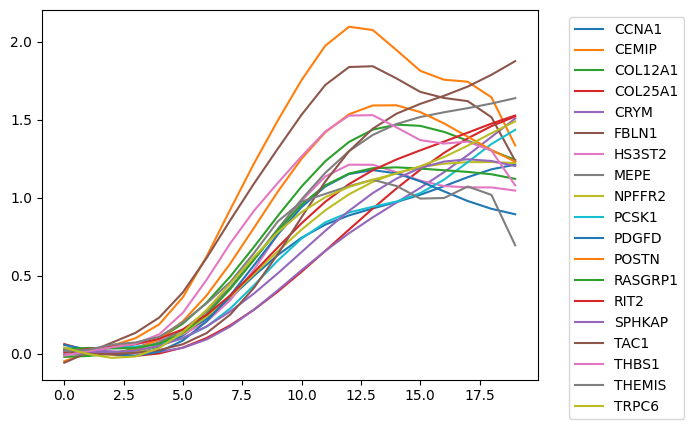

In [179]:
pd.DataFrame(output[folder][0][output[folder][2]], index=adata.var_names[output[folder][2]]).T.plot.line()
plt.legend(bbox_to_anchor=(1.05, 1))

In [190]:
from collections import Counter

added = []
for folder in output:
    print(adata.var_names[output[folder][2]])
    added.extend(adata.var_names[output[folder][2]])

pd.Series(Counter(added)).sort_values()

Index(['CD163', 'CERCAM', 'COL12A1', 'CRYM', 'CXCL8', 'F13A1', 'FBLN1',
       'ITGA8', 'KLF2', 'LAMA2', 'MOBP', 'NLRP3', 'NR4A2', 'RASGRP1', 'SAMD5',
       'ST18', 'SYNPR', 'THBS1', 'THSD7B'],
      dtype='object')
Index(['ANO3', 'CCL4', 'CCNA1', 'CDH12', 'COL12A1', 'CRYM', 'FBLN1', 'GPNMB',
       'HS3ST2', 'HTR2A', 'MBP', 'RIT2', 'ROS1', 'SAMD5', 'SLC17A6', 'SLC26A4',
       'TRPC5', 'WIF1', 'ZDHHC23'],
      dtype='object')
Index(['ANKRD18A', 'CD22', 'CD36', 'CEMIP', 'CLDN11', 'COL12A1', 'COL25A1',
       'CXCL8', 'ELOVL2', 'FBLN1', 'HES1', 'IL7R', 'KLK6', 'KLRB1', 'LAMA2',
       'LOX', 'MAG', 'PCSK6', 'WIF1'],
      dtype='object')
Index(['BTBD11', 'CD3G', 'CEMIP2', 'CTSH', 'DGAT1', 'GAD1', 'GAD2', 'HTR2A',
       'LHX6', 'LRRK1', 'MEPE', 'NPC2', 'OTOGL', 'RSPO2', 'SLIT3', 'SNTB2',
       'TACR1', 'TNF', 'TRHDE'],
      dtype='object')
Index(['ADRA1B', 'ANO3', 'B4GALNT1', 'CCK', 'CCNA1', 'CDH12', 'CRYM', 'CUX2',
       'FSTL4', 'GAD2', 'LAMP5', 'ROS1', 'SCN2A', 'SNCG', 'SORCS1',

ITGA8      1
MOBP       1
ST18       1
SLC26A4    1
MBP        1
          ..
CEMIP      5
TAC1       5
COL12A1    6
CRYM       6
FBLN1      8
Length: 120, dtype: int64

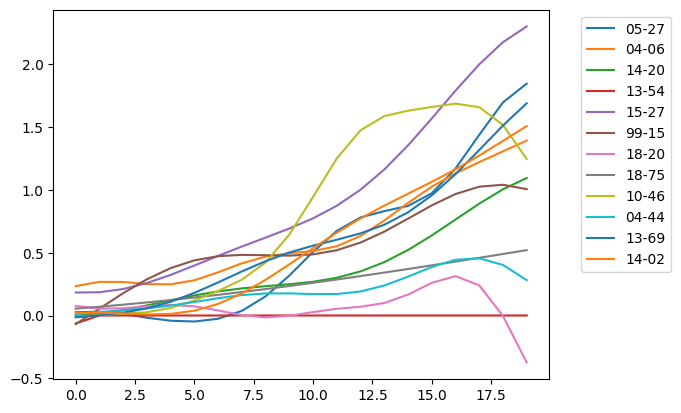

In [203]:
pd.DataFrame([output[folder][0][(adata.var_names == "CRYM").argmax()] for folder in output], index=[folder for folder in output]).T.plot.line()
plt.legend(bbox_to_anchor=(1.05, 1))

# Cell Type Interactions between specimens

In [204]:
per_folder_cell_type_impact = {
    folder.name: pickle.load(open(folder/"neighbor_perturbation.pickle", "rb"))
    for folder in pathlib.Path("/home/jhaberbe/Projects/Personal/ate/output").glob("*")
}

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


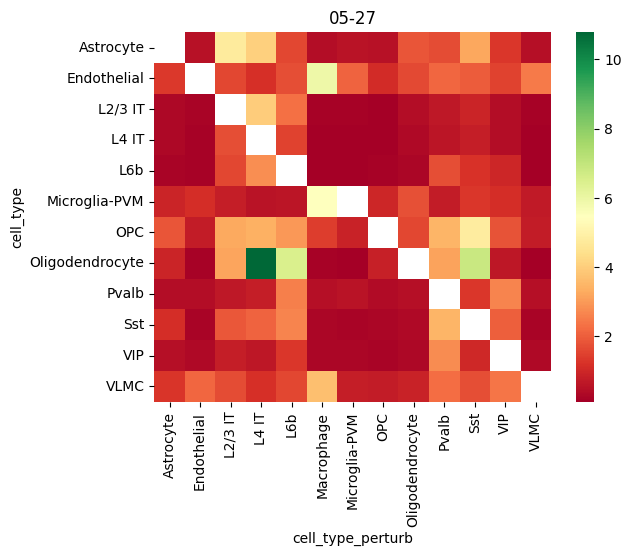

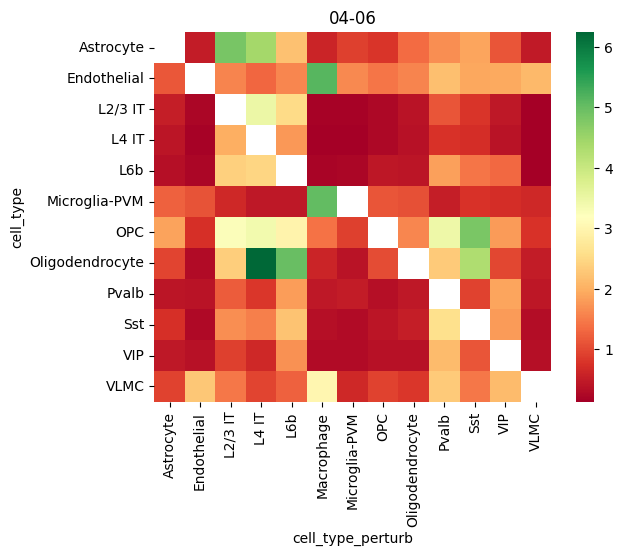

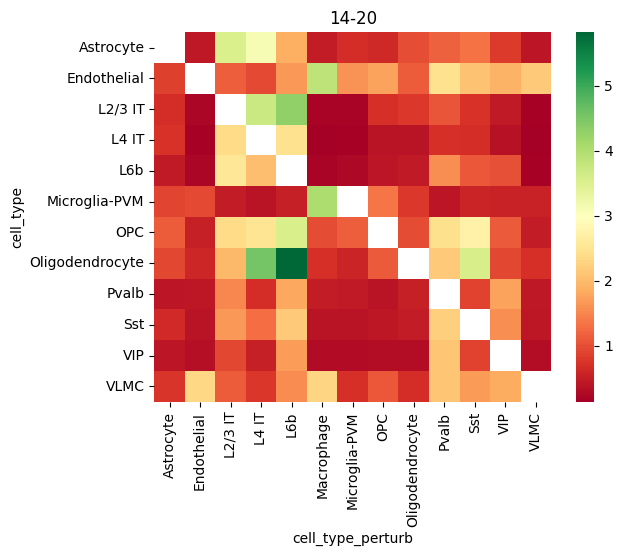

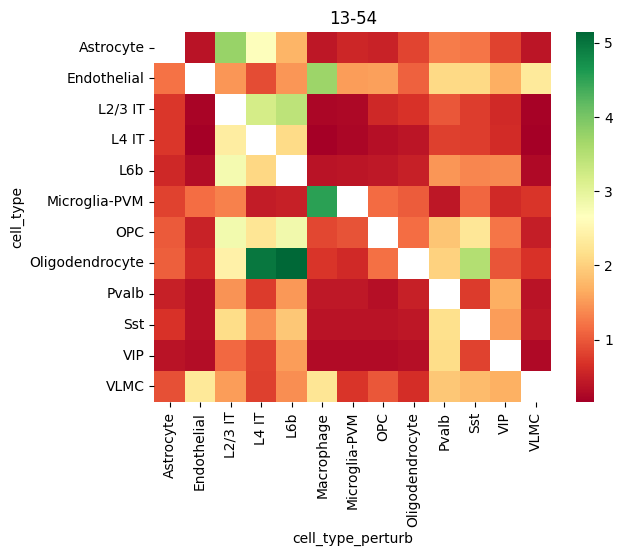

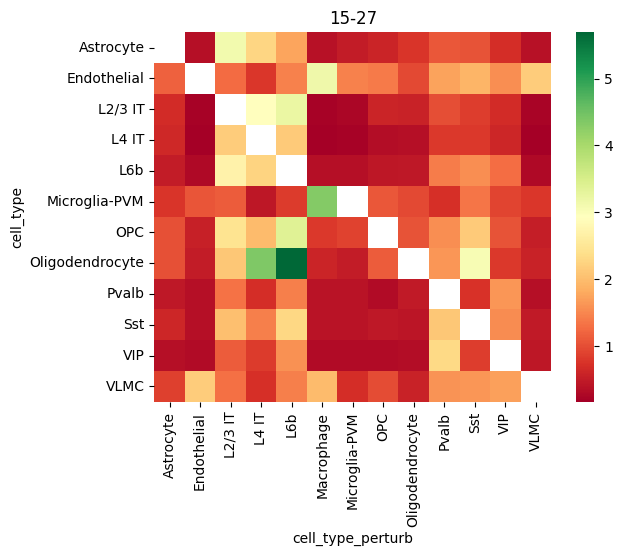

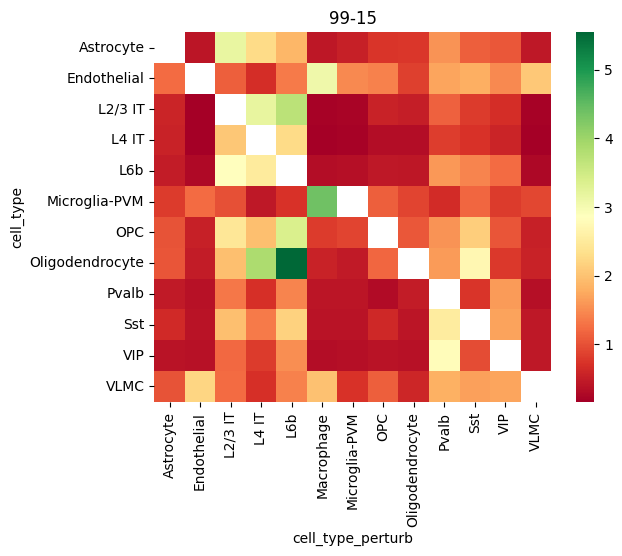

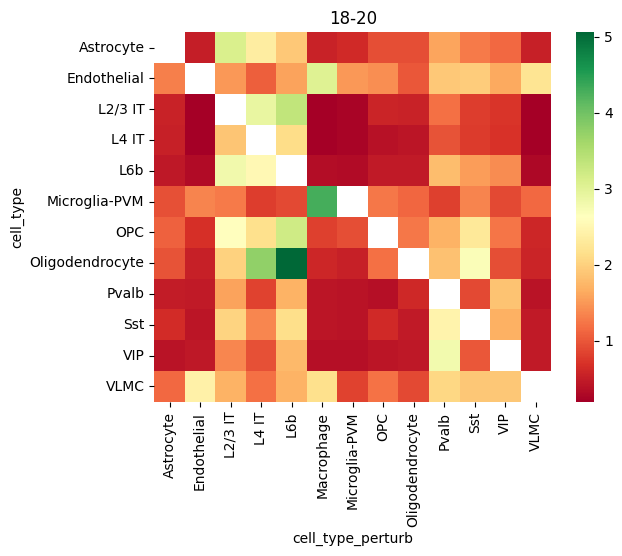

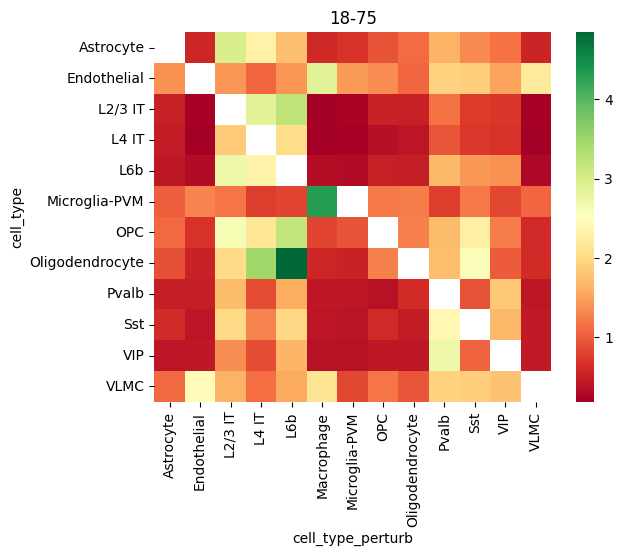

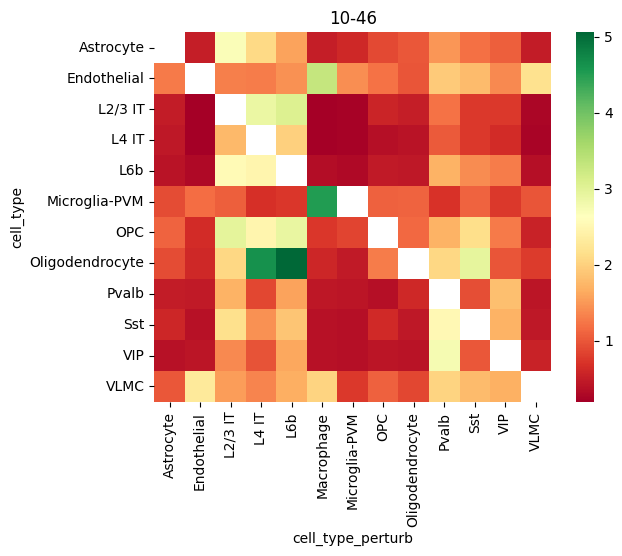

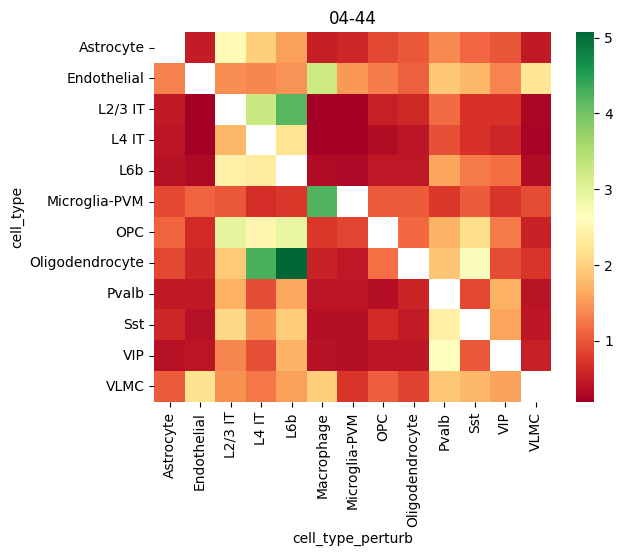

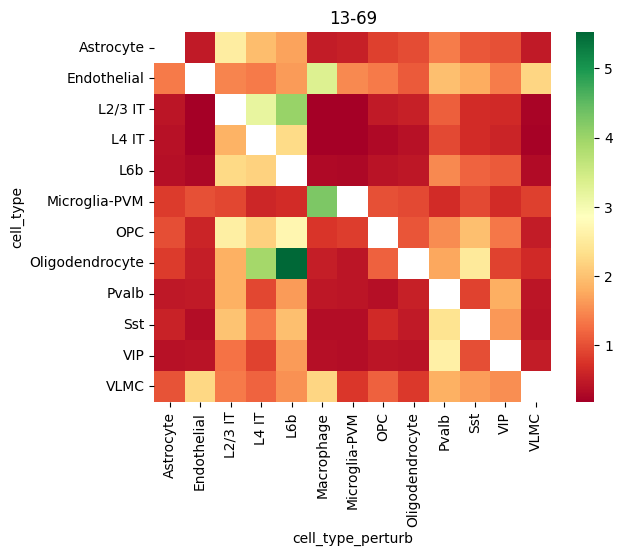

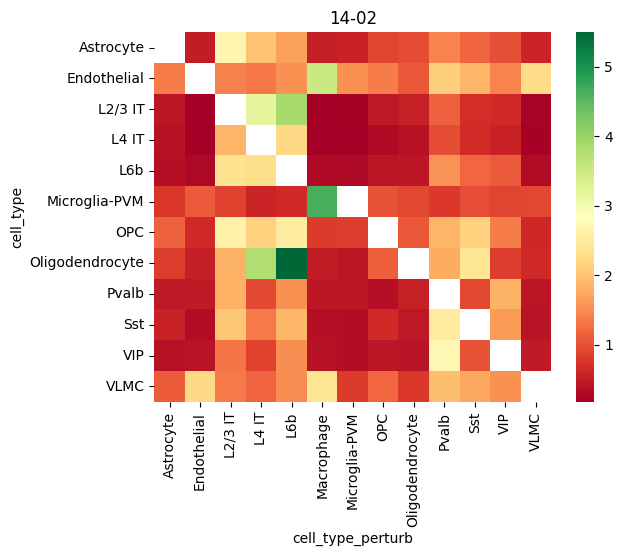

In [211]:
outcomes = []

for folder in tqdm(per_folder_cell_type_impact):
    for cell_type in adata.obs["cell_type"].unique():
        mean_expression = pd.Series(
            adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
            index=adata.var_names
        )

        for cell_type_perturb, average_treatment_effect in per_folder_cell_type_impact[folder][cell_type].items():
            if average_treatment_effect.shape[0] > 200:
                aggregate = {
                    "cell_type": cell_type,
                    "cell_type_perturb": cell_type_perturb,
                    "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
                }
                per_gene = {
                    gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                    for gene in average_treatment_effect.columns
                }
                aggregate.update(per_gene)
                outcomes.append(aggregate)

    heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
    f, ax = plt.subplots()
    sns.heatmap(heatmap, cmap="RdYlGn", ax=ax).set(title=folder)

# Cell Type Lipid Droplet Perturbation Effects

In [214]:
per_folder_cell_type_lipid_impact = {
    folder.name: pickle.load(open(folder/"neighbor_lipid_perturbation.pickle", "rb"))
    for folder in pathlib.Path("/home/jhaberbe/Projects/Personal/ate/output").glob("*")
}

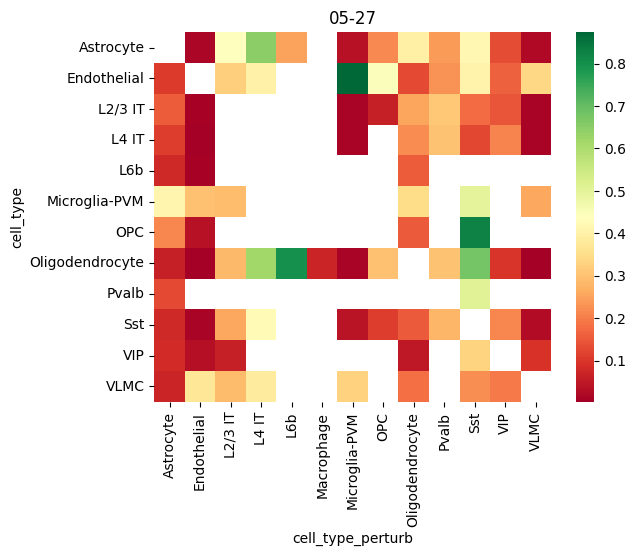

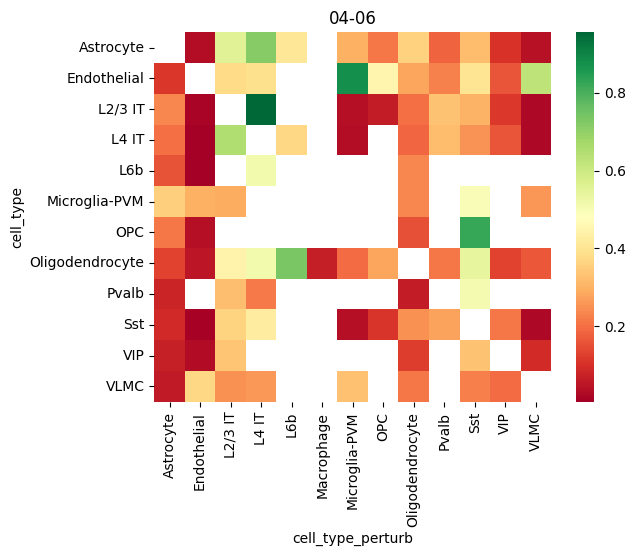

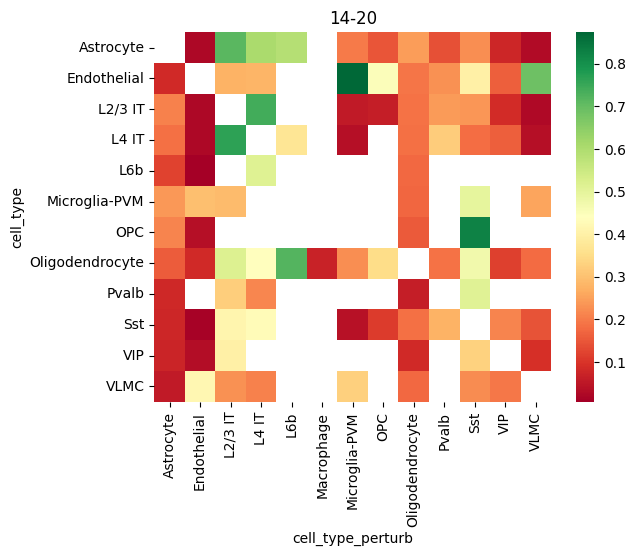

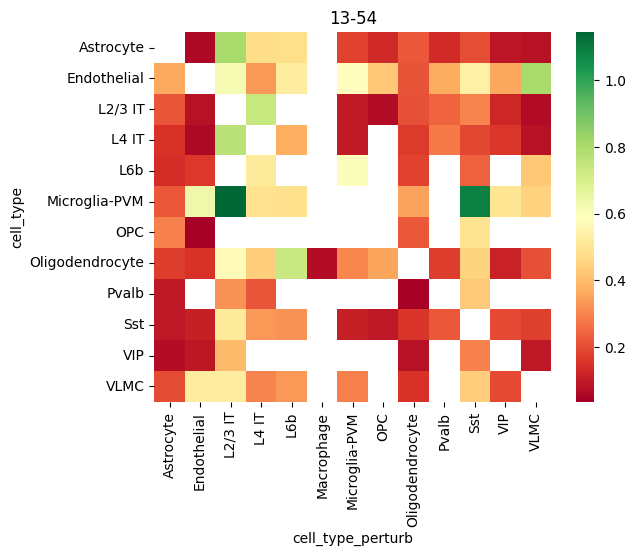

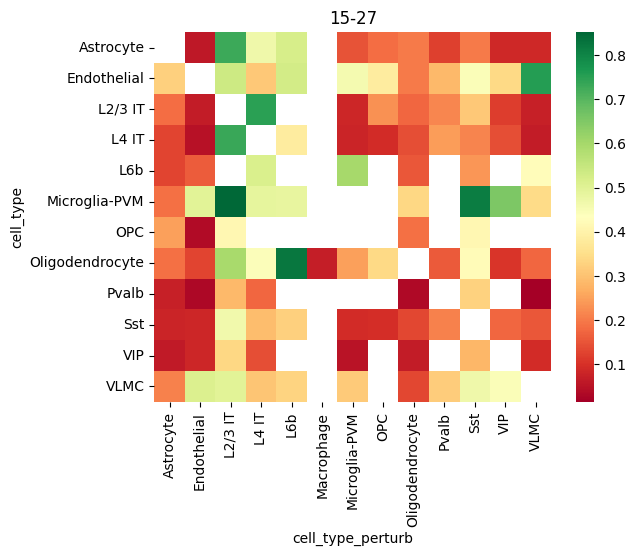

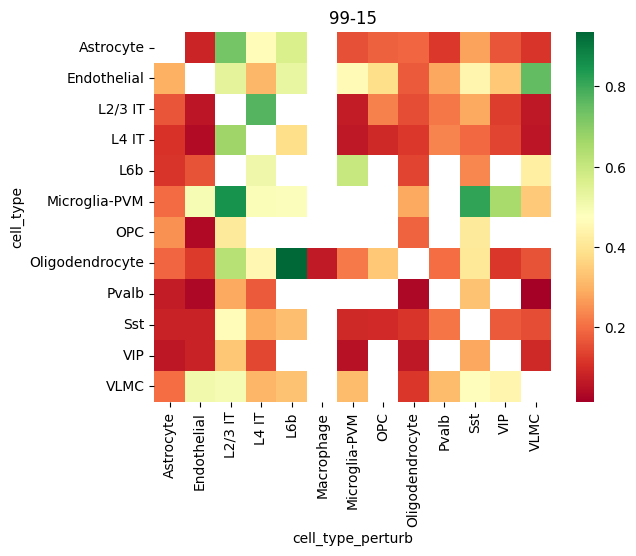

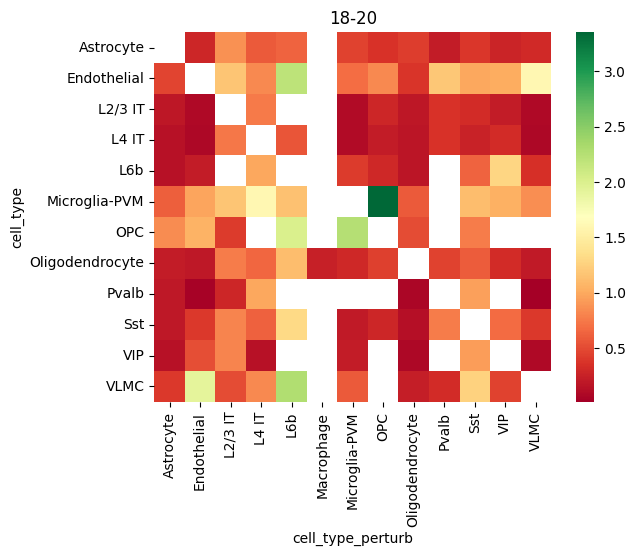

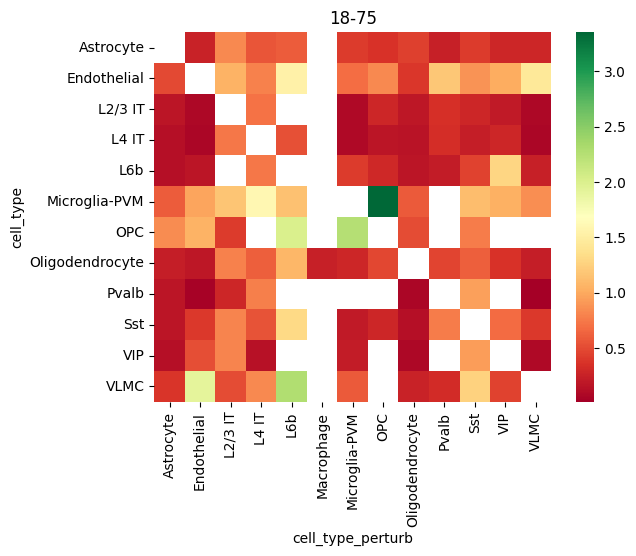

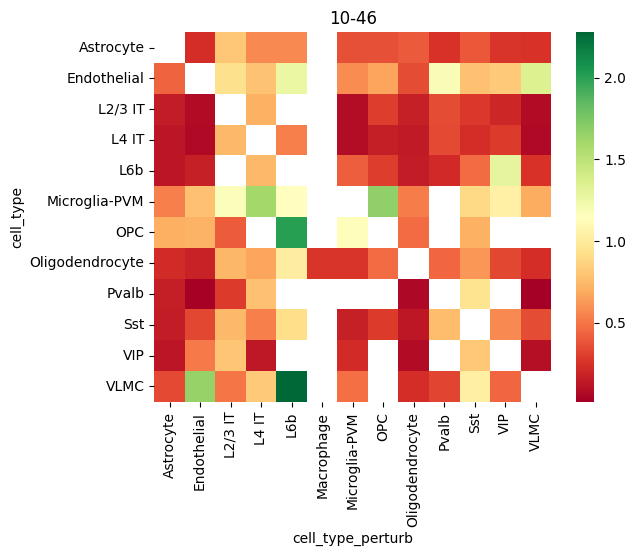

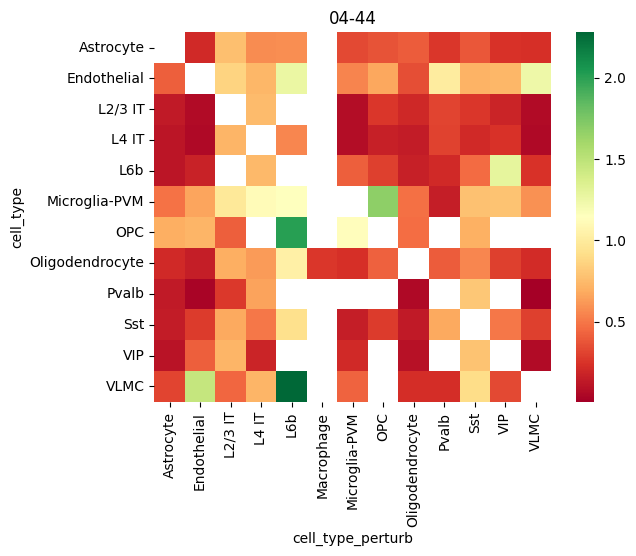

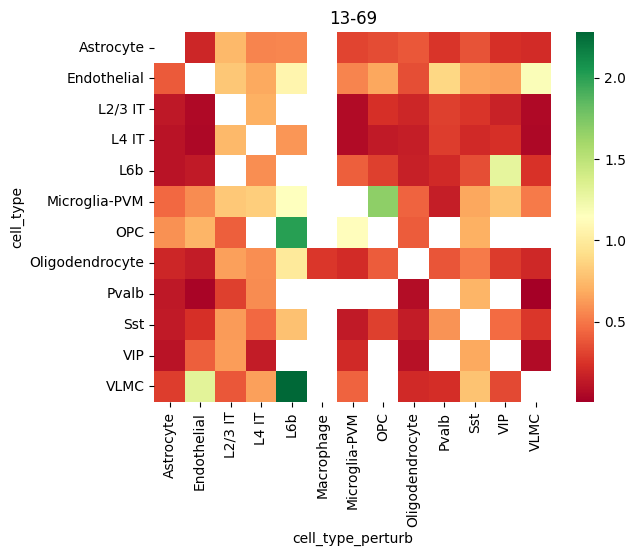

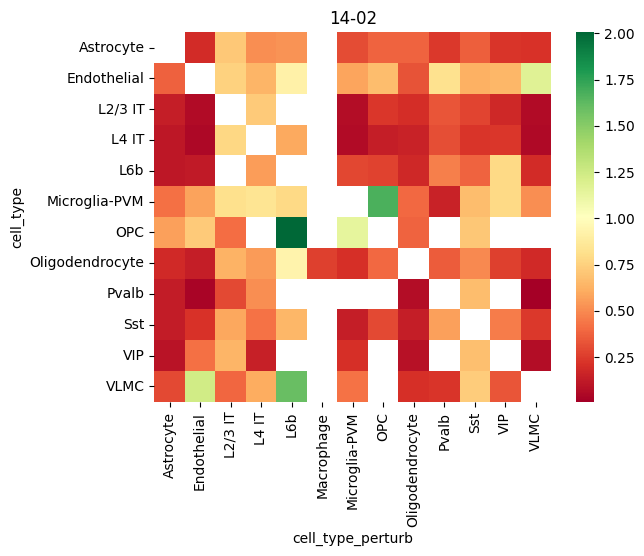

In [219]:
heatmaps = {}

outcomes = []
for folder in per_folder_cell_type_lipid_impact:
    for cell_type in adata.obs["cell_type"].unique():
        mean_expression = pd.Series(
            adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
            index=adata.var_names
        )

        for cell_type_perturb, average_treatment_effect in per_folder_cell_type_lipid_impact[folder][cell_type].items():
            if average_treatment_effect.shape[0] > 200:
                aggregate = {
                    "cell_type": cell_type,
                    "cell_type_perturb": cell_type_perturb,
                    "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
                }
                per_gene = {
                    gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                    for gene in average_treatment_effect.columns
                }
                aggregate.update(per_gene)
                outcomes.append(aggregate)

    heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
    f, ax = plt.subplots()
    sns.heatmap(heatmap, cmap="RdYlGn", ax=ax).set(title=folder)
    heatmaps[folder] = heatmap

<Axes: xlabel='group', ylabel='impact'>

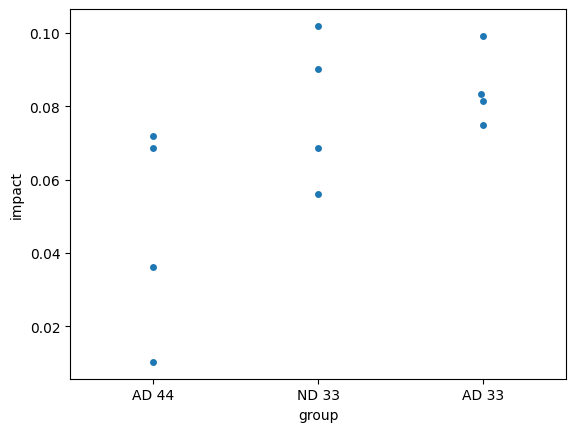

In [249]:
df = adata.obs.drop_duplicates("folder")[["folder", "group"]] \
    .assign(impact = [heatmaps[folder]["Microglia-PVM"]["L2/3 IT"] for folder in df["folder"]])

sns.swarmplot(
    df, 
    x="group",
    y="impact"
)

<Axes: xlabel='group', ylabel='impact'>

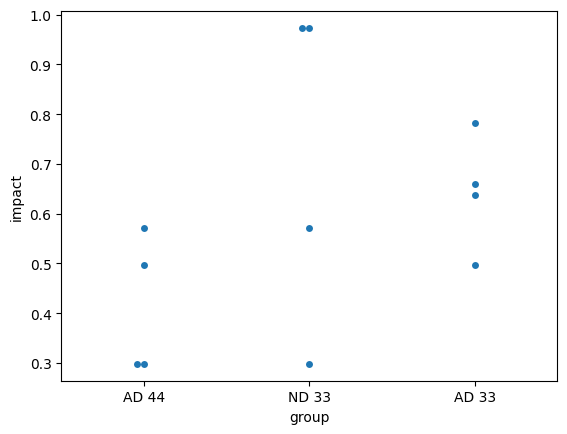

In [250]:
df = adata.obs.drop_duplicates("folder")[["folder", "group"]] \
    .assign(impact = [heatmaps[folder]["Endothelial"]["Microglia-PVM"] for folder in df["folder"]])

sns.swarmplot(
    df, 
    x="group",
    y="impact"
)

# What tends to change the most?

In [303]:
import pandas as pd
from scipy.stats import ttest_ind
from itertools import combinations

def test_group_differences(df, group_column="group", alpha=0.05):
    # Separate gene columns from the group
    gene_columns = df.columns.difference([group_column])
    
    # Get unique group labels
    groups = df[group_column].unique()
    
    # Go through all pairwise combinations of groups
    for group_a, group_b in combinations(groups, 2):
        print(f"\nComparing groups: {group_a} vs {group_b}")
        df_a = df[df[group_column] == group_a]
        df_b = df[df[group_column] == group_b]
        
        for gene in gene_columns:
            values_a = df_a[gene].dropna()
            values_b = df_b[gene].dropna()
            
            # Ensure there are at least 2 values in both groups
            if len(values_a) >= 2 and len(values_b) >= 2:
                stat, pval = ttest_ind(values_a, values_b, equal_var=False)
                if pval < alpha:
                    print(f"  {gene}: p={pval:.4e}")


Comparing groups: AD 44 vs ND 33
  RGS16: p=4.9033e-02

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33


<Axes: xlabel='group', ylabel='RGS16'>

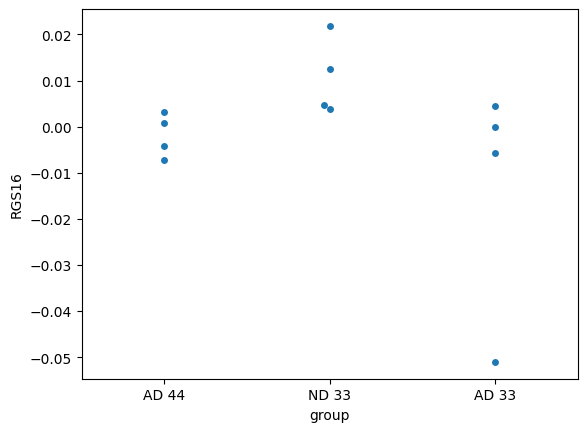

In [294]:
genes = pd.DataFrame({
    folder: per_folder_cell_type_impact[folder]["Microglia-PVM"]["L2/3 IT"].mean(axis=0).sort_values()
    for folder in per_folder_cell_type_impact
})

table = genes.T.assign(group = adata.obs.drop_duplicates("folder")[["folder", "group"]].set_index("folder")["group"])

test_group_differences(table)

sns.swarmplot(
    table,
    x="group",
    y="RGS16"
)


Comparing groups: AD 44 vs ND 33
  CXCL8: p=3.2205e-03

Comparing groups: AD 44 vs AD 33
  MYO16: p=1.0559e-02

Comparing groups: ND 33 vs AD 33
  APOE: p=1.0304e-02


<Axes: xlabel='group', ylabel='CXCL8'>

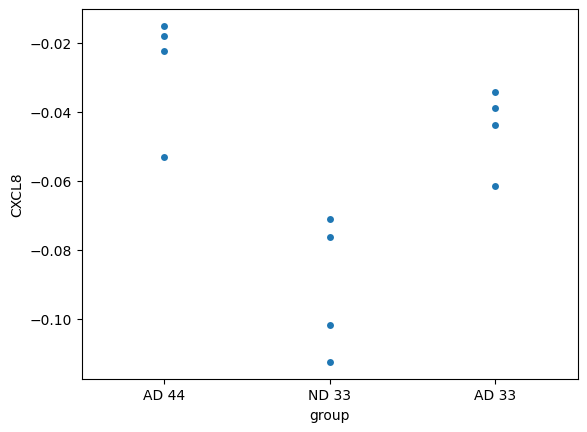

In [302]:
genes = pd.DataFrame({
    folder: per_folder_cell_type_impact[folder]["Endothelial"]["Microglia-PVM"].mean(axis=0).sort_values()
    for folder in per_folder_cell_type_impact
})

table = genes.T.assign(group = adata.obs.drop_duplicates("folder")[["folder", "group"]].set_index("folder")["group"])

test_group_differences(table, alpha=0.011)

sns.swarmplot(
    table,
    x="group",
    y="CXCL8"
)


Comparing groups: AD 44 vs ND 33
  CAMP: p=2.9109e-03
  SLC25A20: p=1.0490e-02

Comparing groups: AD 44 vs AD 33
  PDE4B: p=8.5802e-03
  SLC25A20: p=5.7201e-04

Comparing groups: ND 33 vs AD 33


<Axes: xlabel='group', ylabel='SLC25A20'>

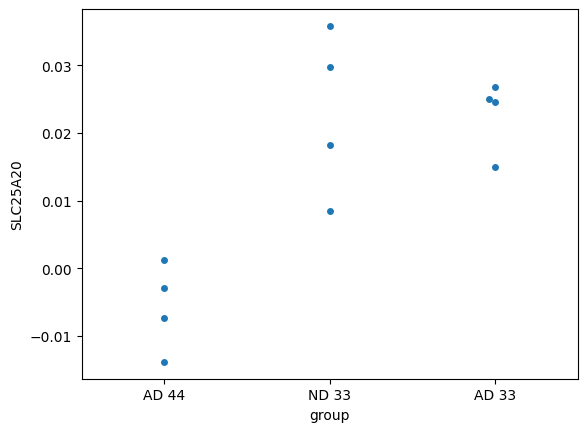

In [306]:
genes = pd.DataFrame({
    folder: per_folder_cell_type_impact[folder]["Endothelial"]["VLMC"].mean(axis=0).sort_values()
    for folder in per_folder_cell_type_impact
})

table = genes.T.assign(group = adata.obs.drop_duplicates("folder")[["folder", "group"]].set_index("folder")["group"])

test_group_differences(table, alpha=0.011)

sns.swarmplot(
    table,
    x="group",
    y="SLC25A20"
)

In [308]:
for cell_type in per_folder_cell_type_impact[folder]:
    for cell_type_perturb in per_folder_cell_type_impact[folder][cell_type]:
        print(cell_type, cell_type_perturb)
        genes = pd.DataFrame({
            folder: per_folder_cell_type_impact[folder][cell_type][cell_type_perturb].mean(axis=0).sort_values()
            for folder in per_folder_cell_type_impact
        })

        table = genes.T.assign(group = adata.obs.drop_duplicates("folder")[["folder", "group"]].set_index("folder")["group"])

        test_group_differences(table, alpha=0.001)

Oligodendrocyte Microglia-PVM

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
  PTCHD4: p=1.0528e-04
Oligodendrocyte VIP

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte Sst

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte L2/3 IT

Comparing groups: AD 44 vs ND 33
  MAL: p=4.6001e-04

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte L4 IT

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte Astrocyte

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte Endothelial

Comparing groups: AD 44 vs ND 33

Comparing groups: AD 44 vs AD 33

Comparing groups: ND 33 vs AD 33
Oligodendrocyte OPC

Comparing groups: AD 44 vs ND 33

Comparing groups: 

```
Oligodendrocyte Microglia-PVM
Comparing groups: ND 33 vs AD 33
  PTCHD4: p=1.0528e-04

Oligodendrocyte L2/3 IT
Comparing groups: AD 44 vs ND 33
  MAL: p=4.6001e-04

Microglia-PVM Pvalb
Comparing groups: AD 44 vs AD 33
  SFRP2: p=9.3691e-05

Microglia-PVM L6b
Comparing groups: AD 44 vs ND 33
  PLIN2: p=4.8622e-04

VIP Sst
Comparing groups: AD 44 vs ND 33
  IGF2R: p=3.9838e-04

Sst L4 IT
Comparing groups: ND 33 vs AD 33
  TGFB1: p=1.9289e-04

L2/3 IT Endothelial
Comparing groups: AD 44 vs ND 33
  CCNA1: p=6.4200e-05

L4 IT OPC
Comparing groups: AD 44 vs AD 33
  ATF3: p=1.8646e-04

Comparing groups: ND 33 vs AD 33
  ATF3: p=2.2399e-04
  SREBF1: p=5.4062e-04

Astrocyte Microglia-PVM
Comparing groups: AD 44 vs AD 33
  SLC17A6: p=5.3687e-04

Astrocyte VIP
Comparing groups: AD 44 vs ND 33
  CENPF: p=5.9117e-04

Comparing groups: AD 44 vs AD 33
  FILIP1: p=7.4994e-04

Astrocyte L2/3 IT
Comparing groups: AD 44 vs AD 33
  PSEN1: p=9.3300e-04

Astrocyte L4 IT
Comparing groups: AD 44 vs ND 33
  CX3CR1: p=4.3424e-04

Comparing groups: AD 44 vs AD 33
  CX3CR1: p=5.4324e-04

Astrocyte Endothelial
Comparing groups: AD 44 vs AD 33
  CCL2: p=1.2703e-04

Astrocyte Pvalb
Comparing groups: AD 44 vs AD 33
  HHATL: p=5.6980e-04
  SRGN: p=3.3954e-05
  TGFB2: p=3.5611e-04

Astrocyte L6b
Comparing groups: AD 44 vs ND 33
  EFHD1: p=8.3859e-04
  ITGB2: p=5.2828e-04

Comparing groups: AD 44 vs AD 33
  CX3CR1: p=4.2317e-04
  ITGB2: p=3.4720e-04
  P2RY13: p=7.6457e-04
  PTPRC: p=7.0064e-04

Astrocyte Macrophage
Comparing groups: AD 44 vs AD 33
  ANO3: p=3.7587e-04
  CCR2: p=3.6603e-04
  RORB: p=7.5417e-04

Endothelial Sst
Comparing groups: ND 33 vs AD 33
  CD83: p=1.7326e-04

Endothelial Pvalb
Comparing groups: AD 44 vs AD 33
  ACSL1: p=4.5615e-04
  ITGAX: p=2.4235e-04

Comparing groups: ND 33 vs AD 33
  AIF1: p=7.8930e-04

Endothelial VLMC
Comparing groups: AD 44 vs AD 33
  SLC25A20: p=5.7201e-04

OPC VIP
Comparing groups: AD 44 vs AD 33
  TREM2: p=4.6224e-04

OPC Macrophage
Comparing groups: ND 33 vs AD 33
  CD3G: p=7.4944e-04
  NRP1: p=8.6382e-04

Pvalb Oligodendrocyte
Comparing groups: AD 44 vs AD 33
  CRHBP: p=9.2719e-04

Pvalb Microglia-PVM
Comparing groups: AD 44 vs AD 33
  DNER: p=9.5791e-04

Pvalb Sst
Comparing groups: AD 44 vs AD 33
  SLC26A4: p=9.2666e-04

Pvalb Macrophage
Comparing groups: AD 44 vs AD 33
  HSP90AA1: p=2.4560e-04

VLMC Sst
Comparing groups: ND 33 vs AD 33
  MS4A4E: p=5.5293e-04

VLMC L2/3 IT
Comparing groups: AD 44 vs ND 33
  ADAMTS12: p=2.6812e-04

VLMC Endothelial
Comparing groups: AD 44 vs AD 33
  GPR183: p=6.6163e-04
  
VLMC L6b
Comparing groups: AD 44 vs AD 33
  HLA-DMB: p=8.7802e-04

VLMC Macrophage
Comparing groups: AD 44 vs AD 33
  CPT1A: p=1.2021e-05
  IDH1: p=3.2981e-05
  LYVE1: p=6.9388e-04


L6b Microglia-PVM
Comparing groups: AD 44 vs ND 33
  RAB7A: p=7.8178e-04

L6b L2/3 IT
Comparing groups: AD 44 vs ND 33
  IGFBP3: p=3.6230e-04
```


Comparing groups: AD 44 vs ND 33
  CAPG: p=1.3076e-03
  CX3CR1: p=4.3424e-04
  FCGR3A: p=5.6608e-03
  KIT: p=7.1915e-03
  P2RY13: p=4.8110e-03
  PTPRC: p=3.0435e-03
  TLR1: p=1.0861e-02
  TREM2: p=1.0920e-02
  TRIL: p=5.6915e-03

Comparing groups: AD 44 vs AD 33
  CAPG: p=1.1781e-03
  CD4: p=7.2830e-03
  CLEC7A: p=5.5666e-03
  CX3CR1: p=5.4324e-04
  FCER1G: p=5.4550e-03
  FCGR3A: p=7.4723e-03
  GNLY: p=4.5518e-03
  HEXA: p=4.8659e-03
  ITGAM: p=1.4971e-03
  ITGAX: p=3.9425e-03
  P2RY13: p=3.4953e-03
  PSEN1: p=5.1190e-03
  PTPRC: p=3.7152e-03
  SCD: p=9.0375e-03
  TGFBI: p=6.3408e-03
  TLR1: p=8.8711e-03
  TMIGD3: p=4.3653e-03
  TREM2: p=3.8100e-03

Comparing groups: ND 33 vs AD 33


<Axes: xlabel='group', ylabel='CX3CR1'>

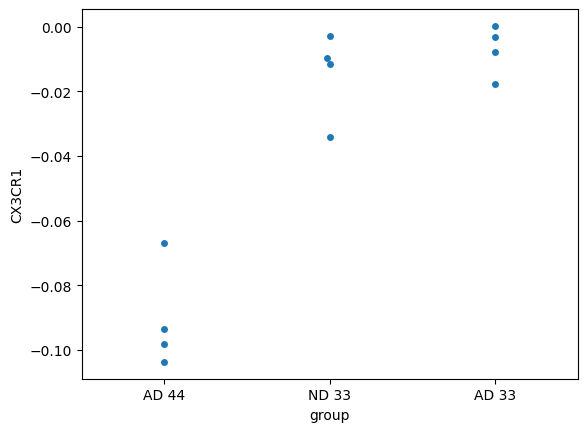

In [310]:
genes = pd.DataFrame({
    folder: per_folder_cell_type_impact[folder]["Astrocyte"]["L4 IT"].mean(axis=0).sort_values()
    for folder in per_folder_cell_type_impact
})

table = genes.T.assign(group = adata.obs.drop_duplicates("folder")[["folder", "group"]].set_index("folder")["group"])

test_group_differences(table, alpha=0.011)

sns.swarmplot(
    table,
    x="group",
    y="CX3CR1"
)